In [1]:
import json
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from tqdm import tqdm
import torch
from pathlib import Path
import random
import networkx as nx
from typing import List, Dict, Tuple, Any, Set
import warnings
warnings.filterwarnings('ignore')

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import pearsonr, spearmanr

# Download NLTK data
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- DATASET LOADING ---
def load_menatqa_dataset(file_path='./MenatQA.json'):
    """Load MenatQA dataset with automatic download."""
    file_path = Path(file_path)
    
    if not file_path.exists():
        import urllib.request
        print(f"Downloading MenatQA to {file_path}...")
        try:
            urllib.request.urlretrieve(
                "https://raw.githubusercontent.com/weiyifan1023/MenatQA/main/datasets/MenatQA.json",
                str(file_path)
            )
            print("Download completed successfully!")
        except Exception as e:
            print(f"Download failed: {e}")
            raise
    
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    print(f"Loaded MenatQA dataset with {len(data)} examples")
    return data

def extract_reasoning_hops(example):
    """Extract reasoning complexity for hop-wise analysis."""
    question = example.get('question', '')
    answer = example.get('answer', '')
    q_type = example.get('type', '')
    time_scope = example.get('time_scope', '')
    
    sentences = [s.strip() for s in question.split('.') if s.strip()]
    clauses = len([c for c in re.split(r'and|or|but|because|when|if', question.lower()) if c.strip()])
    capitalized_words = len([w for w in question.split() if w and w[0].isupper()])
    
    complexity_score = 1
    complexity_score += min(1, len(sentences) - 1)
    complexity_score += min(1, (clauses - 1) // 2)
    complexity_score += min(1, capitalized_words // 3)
    if time_scope:
        complexity_score += 1
    complexity_score = min(4, max(1, complexity_score))
    
    hops = []
    hops.append(f"Understand the question: {question}")
    if complexity_score >= 2:
        if time_scope:
            hops.append(f"Identify time context: {time_scope}")
        else:
            hops.append(f"Recognize question type: {q_type}")
    if complexity_score >= 3:
        hops.append("Retrieve relevant facts and information")
    if complexity_score >= 4:
        hops.append("Analyze relationships between facts")
    hops.append(f"Formulate answer: {answer}")
    
    return hops, complexity_score

def preprocess_dataset(data):
    """Preprocess MenatQA dataset for comprehensive evaluation."""
    processed_data = []
    hop_counts = {1: 0, 2: 0, 3: 0, 4: 0}
    
    for item in data:
        gold_hops, complexity_score = extract_reasoning_hops(item)
        hop_counts[min(4, complexity_score)] += 1
        
        entry = {
            'ID': item.get('ID', ''),
            'question': item.get('question', ''),
            'answer': item.get('answer', ''),
            'type': item.get('type', ''),
            'time_scope': item.get('time_scope', ''),
            'gold_hops': gold_hops,
            'hop_count': complexity_score,
            'model_prediction': '',
            'model_explanation': '',
            'model_reasoning_steps': [],
            'faithfulness_score': 0.0,
            'plausibility_score': 0.0,
            'hallucination_indicator': False
        }
        processed_data.append(entry)
    
    df = pd.DataFrame(processed_data)
    df['hop_category'] = pd.cut(
        df['hop_count'],
        bins=[-1, 1, 2, 3, float('inf')],
        labels=['1-hop', '2-hop', '3-hop', '4+-hop']
    )
    
    print(f"Dataset preprocessed: {len(df)} questions")
    for i in range(1, 5):
        print(f"{i}-hop questions: {hop_counts[i]} ({hop_counts[i]/len(df):.1%})")
    
    return df

# --- QWEN MODEL SETUP ---
class QwenExplanationModel:
    """Qwen model for explanation generation and evaluation."""
    
    def __init__(self, model_name="Qwen/Qwen2-0.5B", device="auto"):
        print(f"Loading {model_name}...")
        self.model_name = model_name
        
        # Try Qwen3-0.6B first, fallback to available models
        models_to_try = [
            "Qwen/Qwen3-0.6B",
            "Qwen/Qwen2-0.5B", 
            "Qwen/Qwen2-1.5B",
            model_name
        ]
        
        self.tokenizer = None
        self.model = None
        
        for model_to_try in models_to_try:
            try:
                print(f"Attempting to load {model_to_try}...")
                self.tokenizer = AutoTokenizer.from_pretrained(model_to_try, trust_remote_code=True)
                self.model = AutoModelForCausalLM.from_pretrained(
                    model_to_try,
                    trust_remote_code=True,
                    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
                    device_map=device
                )
                self.model_name = model_to_try
                print(f"Successfully loaded {model_to_try}")
                break
            except Exception as e:
                print(f"Failed to load {model_to_try}: {e}")
                continue
        
        if self.model is None:
            raise Exception("Failed to load any Qwen model")
        
        # Add padding token if not present
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            
        self.generator = pipeline(
            "text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            device_map=device,
            max_new_tokens=512,
            do_sample=True,
            temperature=0.1,
            pad_token_id=self.tokenizer.eos_token_id
        )
        
        # Load semantic similarity model for faithfulness evaluation
        print("Loading semantic similarity model...")
        self.semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
        
    def generate_explanation(self, question: str, max_length: int = 512) -> Tuple[str, str, List[str]]:
        """Generate answer with detailed explanation."""
        prompt = f"""Answer the following question and provide a detailed explanation of your reasoning process.

Question: {question}

Please structure your response as:
1. Step-by-step reasoning (show each logical step)
2. Final answer

Your explanation should be clear and show exactly how you arrived at the answer.

Reasoning steps:"""

        try:
            result = self.generator(
                prompt,
                max_new_tokens=max_length,
                do_sample=True,
                temperature=0.1,
                pad_token_id=self.tokenizer.eos_token_id
            )
            
            generated_text = result[0]['generated_text']
            response = generated_text[len(prompt):].strip()
            
            # Parse reasoning steps and final answer
            lines = response.split('\n')
            reasoning_steps = []
            final_answer = ""
            
            for line in lines:
                line = line.strip()
                if re.match(r'^\d+\.', line) or line.startswith('-') or line.startswith('•'):
                    reasoning_steps.append(re.sub(r'^\d+\.|-|•', '', line).strip())
                elif line.startswith('Answer:') or line.startswith('Final answer:'):
                    final_answer = re.sub(r'^(Answer|Final answer):', '', line, flags=re.IGNORECASE).strip()
                elif line and not final_answer and reasoning_steps:
                    # Likely the final answer without explicit label
                    final_answer = line
            
            if not final_answer and reasoning_steps:
                final_answer = reasoning_steps[-1]
            
            if not final_answer:
                final_answer = response.split('\n')[-1] if response else "No answer generated"
            
            full_explanation = '\n'.join(reasoning_steps) if reasoning_steps else response
            
            return final_answer, full_explanation, reasoning_steps
            
        except Exception as e:
            print(f"Error generating explanation: {e}")
            return "Error in generation", "Error in explanation", []

# --- FAITHFULNESS EVALUATION ---
def evaluate_faithfulness(explanation: str, reasoning_steps: List[str], 
                         question: str, answer: str, semantic_model: SentenceTransformer) -> float:
    """
    Evaluate faithfulness: Does the explanation truly reflect the computation that produced the answer?
    Score: 1-5 (1=completely unfaithful, 5=perfectly faithful)
    """
    if not explanation or not reasoning_steps:
        return 1.0
    
    faithfulness_score = 0.0
    criteria_count = 0
    
    # Criterion 1: Logical flow consistency (25%)
    if len(reasoning_steps) > 1:
        flow_consistency = 0.0
        for i in range(len(reasoning_steps) - 1):
            current_step = reasoning_steps[i]
            next_step = reasoning_steps[i + 1]
            
            # Check if steps logically connect
            similarity = cosine_similarity(
                semantic_model.encode([current_step]).reshape(1, -1),
                semantic_model.encode([next_step]).reshape(1, -1)
            )[0][0]
            
            # Check for logical connectors
            logical_words = ['therefore', 'thus', 'because', 'since', 'so', 'hence', 'as a result']
            has_connectors = any(word in next_step.lower() for word in logical_words)
            
            step_score = (similarity * 0.7) + (0.3 if has_connectors else 0)
            flow_consistency += step_score
        
        flow_consistency /= (len(reasoning_steps) - 1)
        faithfulness_score += flow_consistency * 1.25  # 25% weight
        criteria_count += 1
    
    # Criterion 2: Question-answer alignment (25%)
    question_answer_alignment = 0.0
    
    # Check if explanation addresses the question
    question_similarity = cosine_similarity(
        semantic_model.encode([explanation]).reshape(1, -1),
        semantic_model.encode([question]).reshape(1, -1)
    )[0][0]
    
    # Check if explanation leads to the answer
    answer_similarity = cosine_similarity(
        semantic_model.encode([explanation]).reshape(1, -1),
        semantic_model.encode([answer]).reshape(1, -1)
    )[0][0]
    
    question_answer_alignment = (question_similarity + answer_similarity) / 2
    faithfulness_score += question_answer_alignment * 1.25  # 25% weight
    criteria_count += 1
    
    # Criterion 3: Step necessity (25%)
    step_necessity = 0.0
    if reasoning_steps:
        necessary_steps = 0
        for step in reasoning_steps:
            # Check if step is relevant to question or contributes to answer
            step_relevance = max(
                cosine_similarity(
                    semantic_model.encode([step]).reshape(1, -1),
                    semantic_model.encode([question]).reshape(1, -1)
                )[0][0],
                cosine_similarity(
                    semantic_model.encode([step]).reshape(1, -1),
                    semantic_model.encode([answer]).reshape(1, -1)
                )[0][0]
            )
            
            if step_relevance > 0.3:  # Threshold for relevance
                necessary_steps += 1
        
        step_necessity = necessary_steps / len(reasoning_steps) if reasoning_steps else 0
        faithfulness_score += step_necessity * 1.25  # 25% weight
        criteria_count += 1
    
    # Criterion 4: Factual consistency (25%)
    factual_consistency = 0.0
    
    # Check for contradictions within explanation
    if len(reasoning_steps) > 1:
        contradiction_penalty = 0
        for i, step1 in enumerate(reasoning_steps):
            for j, step2 in enumerate(reasoning_steps[i+1:], i+1):
                # Simple contradiction detection using negation patterns
                negation_words = ['not', 'no', 'never', 'none', 'neither', 'nor']
                step1_words = set(step1.lower().split())
                step2_words = set(step2.lower().split())
                
                # Check for direct contradictions
                if any(word in step1_words and f"not {word}" in step2.lower() for word in step1_words):
                    contradiction_penalty += 0.1
                elif any(word in step2_words and f"not {word}" in step1.lower() for word in step2_words):
                    contradiction_penalty += 0.1
        
        factual_consistency = max(0, 1.0 - contradiction_penalty)
    else:
        factual_consistency = 1.0
    
    faithfulness_score += factual_consistency * 1.25  # 25% weight
    criteria_count += 1
    
    # Normalize to 1-5 scale
    if criteria_count > 0:
        normalized_score = (faithfulness_score / criteria_count) * 4 + 1  # Convert to 1-5 scale
        return min(5.0, max(1.0, normalized_score))
    
    return 1.0

def evaluate_plausibility(explanation: str, reasoning_steps: List[str], 
                         question: str, semantic_model: SentenceTransformer) -> float:
    """
    Evaluate plausibility: Is the explanation convincing, regardless of correctness?
    Score: 1-5 (1=completely implausible, 5=very convincing)
    """
    if not explanation or not reasoning_steps:
        return 1.0
    
    plausibility_score = 0.0
    criteria_count = 0
    
    # Criterion 1: Clarity and coherence (30%)
    clarity_score = 0.0
    
    # Check explanation length (not too short, not too verbose)
    explanation_length = len(explanation.split())
    length_score = 1.0
    if explanation_length < 10:
        length_score = 0.5  # Too short
    elif explanation_length > 200:
        length_score = 0.7  # Too verbose
    
    # Check for clear structure
    structure_indicators = ['first', 'second', 'then', 'next', 'finally', 'therefore']
    structure_score = min(1.0, sum(1 for indicator in structure_indicators 
                                 if indicator in explanation.lower()) * 0.2)
    
    clarity_score = (length_score + structure_score) / 2
    plausibility_score += clarity_score * 1.5  # 30% weight
    criteria_count += 1
    
        # Criterion 2: Logical flow and transitions (25%)
    flow_score = 0.0
    if len(reasoning_steps) > 1:
        # Check for smooth transitions between steps
        transition_quality = 0.0
        transition_words = ['because', 'therefore', 'thus', 'since', 'so', 'hence', 
                          'as a result', 'consequently', 'furthermore', 'moreover', 'however']
        
        for i in range(len(reasoning_steps) - 1):
            current_step = reasoning_steps[i]
            next_step = reasoning_steps[i + 1]
            
            # Check for explicit transition words
            has_transitions = any(word in next_step.lower() for word in transition_words)
            
            # Check semantic continuity
            semantic_continuity = cosine_similarity(
                semantic_model.encode([current_step]).reshape(1, -1),
                semantic_model.encode([next_step]).reshape(1, -1)
            )[0][0]
            
            step_flow = (0.4 if has_transitions else 0) + (semantic_continuity * 0.6)
            transition_quality += step_flow
        
        flow_score = transition_quality / (len(reasoning_steps) - 1)
    else:
        flow_score = 0.8  # Single step gets moderate score
    
    plausibility_score += flow_score * 1.25  # 25% weight
    criteria_count += 1
    
    # Criterion 3: Domain knowledge appropriateness (25%)
    domain_score = 0.0
    
    # Check for domain-specific terms (Middle Eastern/North African context)
    domain_terms = ['middle east', 'north africa', 'mena', 'arab', 'islamic', 'ottoman', 
                   'persian', 'mediterranean', 'gulf', 'levant', 'maghreb', 'arabia']
    
    explanation_lower = explanation.lower()
    domain_relevance = sum(1 for term in domain_terms if term in explanation_lower)
    domain_score = min(1.0, domain_relevance * 0.3)
    
    # Check for geographical/historical accuracy patterns
    geo_patterns = ['capital', 'country', 'city', 'region', 'border', 'located', 'empire', 'dynasty']
    pattern_usage = sum(1 for pattern in geo_patterns if pattern in explanation_lower)
    pattern_score = min(1.0, pattern_usage * 0.2)
    
    domain_score = (domain_score + pattern_score) / 2
    plausibility_score += domain_score * 1.25  # 25% weight
    criteria_count += 1
    
    # Criterion 4: Confidence and assertiveness (20%)
    confidence_score = 0.0
    
    # Check for confidence indicators
    confident_phrases = ['clearly', 'obviously', 'definitely', 'certainly', 'undoubtedly']
    uncertain_phrases = ['maybe', 'perhaps', 'possibly', 'might', 'could be', 'unclear']
    
    confident_count = sum(1 for phrase in confident_phrases if phrase in explanation_lower)
    uncertain_count = sum(1 for phrase in uncertain_phrases if phrase in explanation_lower)
    
    # Balanced confidence is good (not overconfident, not too uncertain)
    if confident_count > 0 and uncertain_count == 0:
        confidence_score = 0.9
    elif confident_count == 0 and uncertain_count > 2:
        confidence_score = 0.3
    elif confident_count <= 2 and uncertain_count <= 1:
        confidence_score = 0.8
    else:
        confidence_score = 0.6
    
    plausibility_score += confidence_score * 1.0  # 20% weight
    criteria_count += 1
    
    # Normalize to 1-5 scale
    if criteria_count > 0:
        normalized_score = (plausibility_score / criteria_count) * 4 + 1
        return min(5.0, max(1.0, normalized_score))
    
    return 1.0

def detect_hallucination(faithfulness_score: float, plausibility_score: float) -> bool:
    """
    Detect hallucinated reasoning: High plausibility + Low faithfulness
    """
    # Hallucination threshold: plausible but not faithful
    plausibility_threshold = 3.5  # Reasonably convincing
    faithfulness_threshold = 2.5  # Poor faithfulness
    
    return (plausibility_score >= plausibility_threshold and 
            faithfulness_score <= faithfulness_threshold)

# --- COMPREHENSIVE EVALUATION ---
def run_comprehensive_evaluation(df: pd.DataFrame, model: QwenExplanationModel) -> pd.DataFrame:
    """Run comprehensive evaluation with explanation generation and assessment."""
    
    print("Generating explanations and evaluating faithfulness/plausibility...")
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating explanations"):
        try:
            question = row['question']
            gold_answer = row['answer']
            
            # Generate explanation
            pred_answer, explanation, reasoning_steps = model.generate_explanation(question)
            
            # Evaluate faithfulness
            faithfulness = evaluate_faithfulness(
                explanation, reasoning_steps, question, pred_answer, model.semantic_model
            )
            
            # Evaluate plausibility
            plausibility = evaluate_plausibility(
                explanation, reasoning_steps, question, model.semantic_model
            )
            
            # Detect hallucination
            hallucination = detect_hallucination(faithfulness, plausibility)
            
            # Update dataframe
            df.at[idx, 'model_prediction'] = pred_answer
            df.at[idx, 'model_explanation'] = explanation
            df.at[idx, 'model_reasoning_steps'] = reasoning_steps
            df.at[idx, 'faithfulness_score'] = faithfulness
            df.at[idx, 'plausibility_score'] = plausibility
            df.at[idx, 'hallucination_indicator'] = hallucination
            
        except Exception as e:
            print(f"Error processing example {idx}: {e}")
            # Set default values for failed cases
            df.at[idx, 'model_prediction'] = "Error"
            df.at[idx, 'model_explanation'] = "Error in generation"
            df.at[idx, 'model_reasoning_steps'] = []
            df.at[idx, 'faithfulness_score'] = 1.0
            df.at[idx, 'plausibility_score'] = 1.0
            df.at[idx, 'hallucination_indicator'] = False
            continue
    
    return df

# --- ACCURACY METRICS ---
def compute_exact_match(prediction: str, gold: str) -> int:
    """Compute exact match score."""
    return int(str(prediction).strip().lower() == str(gold).strip().lower())

def compute_f1(prediction: str, gold: str) -> float:
    """Compute F1 score."""
    pred_tokens = str(prediction).lower().split()
    gold_tokens = str(gold).lower().split()
    common = set(pred_tokens) & set(gold_tokens)
    if not pred_tokens or not gold_tokens:
        return 0.0
    prec = len(common) / len(pred_tokens)
    rec = len(common) / len(gold_tokens)
    if prec + rec == 0:
        return 0.0
    return 2 * prec * rec / (prec + rec)

def compute_bleu(prediction: str, gold: str) -> float:
    """Compute BLEU score."""
    pred_tokens = str(prediction).lower().split()
    gold_tokens = str(gold).lower().split()
    if not pred_tokens or not gold_tokens:
        return 0.0
    reference = [gold_tokens]
    candidate = pred_tokens
    weights = (0.25, 0.25, 0.25, 0.25)
    chencherry = SmoothingFunction()
    try:
        bleu_score = sentence_bleu(reference, candidate, weights=weights, smoothing_function=chencherry.method1)
    except:
        bleu_score = 0.0
    return bleu_score

def compute_comprehensive_metrics(df: pd.DataFrame) -> Dict:
    """Compute all evaluation metrics."""
    
    # Basic accuracy metrics
    em_scores = [compute_exact_match(row['model_prediction'], row['answer']) 
                for _, row in df.iterrows()]
    f1_scores = [compute_f1(row['model_prediction'], row['answer']) 
                for _, row in df.iterrows()]
    bleu_scores = [compute_bleu(row['model_prediction'], row['answer']) 
                  for _, row in df.iterrows()]
    
    # Explanation quality metrics
    faithfulness_scores = df['faithfulness_score'].tolist()
    plausibility_scores = df['plausibility_score'].tolist()
    hallucination_rates = df['hallucination_indicator'].tolist()
    
    # Hop-wise analysis
    hop_wise_results = {}
    for hop_cat in df['hop_category'].unique():
        if pd.isna(hop_cat):
            continue
        
        subset = df[df['hop_category'] == hop_cat]
        hop_wise_results[str(hop_cat)] = {
            'count': len(subset),
            'EM': np.mean([compute_exact_match(row['model_prediction'], row['answer']) 
                          for _, row in subset.iterrows()]),
            'F1': np.mean([compute_f1(row['model_prediction'], row['answer']) 
                          for _, row in subset.iterrows()]),
            'BLEU': np.mean([compute_bleu(row['model_prediction'], row['answer']) 
                            for _, row in subset.iterrows()]),
            'Faithfulness': np.mean(subset['faithfulness_score']),
            'Plausibility': np.mean(subset['plausibility_score']),
            'Hallucination_Rate': np.mean(subset['hallucination_indicator'])
        }
    
    # Correlation analysis
    faithfulness_plausibility_corr = pearsonr(faithfulness_scores, plausibility_scores)[0]
    faithfulness_accuracy_corr = pearsonr(faithfulness_scores, f1_scores)[0]
    plausibility_accuracy_corr = pearsonr(plausibility_scores, f1_scores)[0]
    
    return {
        'overall_metrics': {
            'Exact_Match': np.mean(em_scores),
            'F1_Score': np.mean(f1_scores),
            'BLEU_Score': np.mean(bleu_scores),
            'Faithfulness': np.mean(faithfulness_scores),
            'Plausibility': np.mean(plausibility_scores),
            'Hallucination_Rate': np.mean(hallucination_rates),
            'Total_Questions': len(df)
        },
        'hop_wise_metrics': hop_wise_results,
        'correlations': {
            'Faithfulness_Plausibility': faithfulness_plausibility_corr,
            'Faithfulness_Accuracy': faithfulness_accuracy_corr,
            'Plausibility_Accuracy': plausibility_accuracy_corr
        },
        'detailed_scores': {
            'faithfulness_scores': faithfulness_scores,
            'plausibility_scores': plausibility_scores,
            'hallucination_indicators': hallucination_rates,
            'accuracy_scores': f1_scores
        }
    }

# --- ADVANCED VISUALIZATIONS ---
def create_comprehensive_visualizations(results: Dict, save_dir: str = './results'):
    """Create comprehensive visualizations for all metrics."""
    os.makedirs(save_dir, exist_ok=True)
    
    # Set up the plotting style
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 10
    
    # 1. Overall Performance Dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Overall metrics bar chart
    overall = results['overall_metrics']
    metrics = ['Exact_Match', 'F1_Score', 'BLEU_Score', 'Faithfulness', 'Plausibility']
    values = [overall[metric] for metric in metrics]
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
    
    bars = ax1.bar(metrics, values, color=colors, alpha=0.8)
    ax1.set_ylabel('Score', fontweight='bold')
    ax1.set_title('Overall Performance Metrics', fontweight='bold', fontsize=14)
    ax1.set_ylim(0, 5)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax1.tick_params(axis='x', rotation=45)
    
    # Faithfulness vs Plausibility scatter plot
    faith_scores = results['detailed_scores']['faithfulness_scores']
    plaus_scores = results['detailed_scores']['plausibility_scores']
    halluc_indicators = results['detailed_scores']['hallucination_indicators']
    
    # Color points by hallucination status
    colors_scatter = ['red' if h else 'blue' for h in halluc_indicators]
    scatter = ax2.scatter(faith_scores, plaus_scores, c=colors_scatter, alpha=0.6)
    ax2.set_xlabel('Faithfulness Score', fontweight='bold')
    ax2.set_ylabel('Plausibility Score', fontweight='bold')
    ax2.set_title('Faithfulness vs Plausibility\n(Red = Hallucination)', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add diagonal line and quadrant labels
    ax2.plot([1, 5], [1, 5], 'k--', alpha=0.5)
    ax2.text(4.5, 2, 'High Plausibility\nLow Faithfulness\n(Hallucination Zone)', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.3))
    
    # Hop-wise performance
    hop_data = results['hop_wise_metrics']
    hop_categories = list(hop_data.keys())
    hop_f1 = [hop_data[cat]['F1'] for cat in hop_categories]
    hop_faith = [hop_data[cat]['Faithfulness'] for cat in hop_categories]
    hop_plaus = [hop_data[cat]['Plausibility'] for cat in hop_categories]
    
    x = np.arange(len(hop_categories))
    width = 0.25
    
    ax3.bar(x - width, hop_f1, width, label='F1 Score', color='#3498db', alpha=0.8)
    ax3.bar(x, hop_faith, width, label='Faithfulness', color='#e74c3c', alpha=0.8)
    ax3.bar(x + width, hop_plaus, width, label='Plausibility', color='#9b59b6', alpha=0.8)
    
    ax3.set_xlabel('Reasoning Complexity', fontweight='bold')
    ax3.set_ylabel('Score', fontweight='bold')
    ax3.set_title('Performance by Reasoning Complexity', fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(hop_categories)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # Hallucination rate by complexity
    hop_halluc = [hop_data[cat]['Hallucination_Rate'] * 100 for cat in hop_categories]
    
    bars_halluc = ax4.bar(hop_categories, hop_halluc, color='#e74c3c', alpha=0.7)
    ax4.set_ylabel('Hallucination Rate (%)', fontweight='bold')
    ax4.set_xlabel('Reasoning Complexity', fontweight='bold')
    ax4.set_title('Hallucination Rate by Complexity', fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for bar, rate in zip(bars_halluc, hop_halluc):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Correlation Heatmap
    plt.figure(figsize=(10, 8))
    
    # Create correlation matrix
    corr_data = {
        'Faithfulness': faith_scores,
        'Plausibility': plaus_scores,
        'F1_Score': results['detailed_scores']['accuracy_scores'],
        'Hallucination': [int(h) for h in halluc_indicators]
    }
    
    corr_df = pd.DataFrame(corr_data)
    correlation_matrix = corr_df.corr()
    
    # Create heatmap
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    
    plt.title('Correlation Matrix: Explanation Quality vs Performance', 
              fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Distribution Analysis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
        # Faithfulness distribution
    ax1.hist(faith_scores, bins=20, color='#e74c3c', alpha=0.7, edgecolor='black')
    ax1.axvline(np.mean(faith_scores), color='blue', linestyle='--', 
                label=f'Mean: {np.mean(faith_scores):.2f}')
    ax1.set_xlabel('Faithfulness Score')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Faithfulness Scores', fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Plausibility distribution
    ax2.hist(plaus_scores, bins=20, color='#9b59b6', alpha=0.7, edgecolor='black')
    ax2.axvline(np.mean(plaus_scores), color='blue', linestyle='--', 
                label=f'Mean: {np.mean(plaus_scores):.2f}')
    ax2.set_xlabel('Plausibility Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Plausibility Scores', fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # F1 Score distribution
    f1_scores = results['detailed_scores']['accuracy_scores']
    ax3.hist(f1_scores, bins=20, color='#2ecc71', alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(f1_scores), color='blue', linestyle='--', 
                label=f'Mean: {np.mean(f1_scores):.2f}')
    ax3.set_xlabel('F1 Score')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of F1 Scores', fontweight='bold')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # Hallucination analysis
    halluc_counts = [sum(halluc_indicators), len(halluc_indicators) - sum(halluc_indicators)]
    labels = ['Hallucinated', 'Non-Hallucinated']
    colors_pie = ['#e74c3c', '#2ecc71']
    
    wedges, texts, autotexts = ax4.pie(halluc_counts, labels=labels, colors=colors_pie, 
                                      autopct='%1.1f%%', startangle=90)
    ax4.set_title('Hallucination Distribution', fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/distribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Detailed Performance Analysis by Question Type
    plt.figure(figsize=(14, 8))
    
    # Group by question types if available
    if 'type' in results.get('question_types', {}):
        # This would need to be implemented based on question types in MenatQA
        pass
    else:
        # Create analysis by complexity and hallucination status
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Performance comparison: Hallucinated vs Non-Hallucinated
        halluc_faith = [f for f, h in zip(faith_scores, halluc_indicators) if h]
        non_halluc_faith = [f for f, h in zip(faith_scores, halluc_indicators) if not h]
        halluc_f1 = [f for f, h in zip(f1_scores, halluc_indicators) if h]
        non_halluc_f1 = [f for f, h in zip(f1_scores, halluc_indicators) if not h]
        
        # Box plots for comparison
        faith_data = [non_halluc_faith, halluc_faith]
        f1_data = [non_halluc_f1, halluc_f1]
        
        bp1 = ax1.boxplot(faith_data, labels=['Non-Hallucinated', 'Hallucinated'], 
                         patch_artist=True)
        bp1['boxes'][0].set_facecolor('#2ecc71')
        bp1['boxes'][1].set_facecolor('#e74c3c')
        ax1.set_ylabel('Faithfulness Score')
        ax1.set_title('Faithfulness: Hallucinated vs Non-Hallucinated', fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        
        bp2 = ax2.boxplot(f1_data, labels=['Non-Hallucinated', 'Hallucinated'], 
                         patch_artist=True)
        bp2['boxes'][0].set_facecolor('#2ecc71')
        bp2['boxes'][1].set_facecolor('#e74c3c')
        ax2.set_ylabel('F1 Score')
        ax2.set_title('Accuracy: Hallucinated vs Non-Hallucinated', fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{save_dir}/hallucination_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

def print_comprehensive_results(results: Dict, model_name: str):
    """Print detailed results summary."""
    print("\n" + "="*80)
    print(f"COMPREHENSIVE EVALUATION RESULTS - {model_name}")
    print("="*80)
    
    overall = results['overall_metrics']
    print(f"\n📊 OVERALL PERFORMANCE:")
    print(f"   • Total Questions Evaluated: {overall['Total_Questions']}")
    print(f"   • Exact Match: {overall['Exact_Match']:.3f}")
    print(f"   • F1 Score: {overall['F1_Score']:.3f}")
    print(f"   • BLEU Score: {overall['BLEU_Score']:.3f}")
    
    print(f"\n🔍 EXPLANATION QUALITY:")
    print(f"   • Average Faithfulness: {overall['Faithfulness']:.3f}/5.0")
    print(f"   • Average Plausibility: {overall['Plausibility']:.3f}/5.0")
    print(f"   • Hallucination Rate: {overall['Hallucination_Rate']:.1%}")
    
    print(f"\n📈 CORRELATIONS:")
    corr = results['correlations']
    print(f"   • Faithfulness ↔ Plausibility: {corr['Faithfulness_Plausibility']:.3f}")
    print(f"   • Faithfulness ↔ Accuracy: {corr['Faithfulness_Accuracy']:.3f}")
    print(f"   • Plausibility ↔ Accuracy: {corr['Plausibility_Accuracy']:.3f}")
    
    print(f"\n🎯 PERFORMANCE BY REASONING COMPLEXITY:")
    hop_metrics = results['hop_wise_metrics']
    for hop_cat, metrics in hop_metrics.items():
        print(f"\n   {hop_cat} Questions (n={metrics['count']}):")
        print(f"      ├─ F1 Score: {metrics['F1']:.3f}")
        print(f"      ├─ Faithfulness: {metrics['Faithfulness']:.3f}")
        print(f"      ├─ Plausibility: {metrics['Plausibility']:.3f}")
        print(f"      └─ Hallucination Rate: {metrics['Hallucination_Rate']:.1%}")
    
    # Interpretation
    print(f"\n💡 KEY INSIGHTS:")
    if overall['Hallucination_Rate'] > 0.2:
        print(f"   ⚠️  High hallucination rate detected ({overall['Hallucination_Rate']:.1%})")
    if corr['Faithfulness_Plausibility'] < 0.5:
        print(f"   ⚠️  Low correlation between faithfulness and plausibility")
    if overall['Faithfulness'] < 3.0:
        print(f"   ⚠️  Low faithfulness scores indicate reasoning issues")
    if overall['Plausibility'] > 3.5 and overall['Faithfulness'] < 3.0:
        print(f"   🚨 High plausibility with low faithfulness suggests systematic hallucination")
    
    print("\n" + "="*80)

# --- MAIN EXECUTION ---
def main():
    """Run the complete evaluation pipeline."""
    print("🚀 MenatQA Comprehensive Evaluation with Explanation Analysis")
    print("="*80)
    
    # Load dataset
    print("\n1️⃣ Loading MenatQA dataset...")
    try:
        data = load_menatqa_dataset('./MenatQA.json')
        df = preprocess_dataset(data)
        print(f"✅ Successfully loaded and preprocessed {len(df)} questions")
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        print("📝 Creating sample dataset for demonstration...")
        sample_data = [
            {'ID': 1, 'question': 'What is the capital of Egypt?', 'answer': 'Cairo', 'type': 'geography'},
            {'ID': 2, 'question': 'Which empire controlled most of the Middle East in the 16th century?', 'answer': 'Ottoman Empire', 'type': 'history'},
            {'ID': 3, 'question': 'What language is primarily spoken in Morocco?', 'answer': 'Arabic', 'type': 'culture'},
            {'ID': 4, 'question': 'Which country borders both Iraq and Iran?', 'answer': 'Turkey', 'type': 'geography'},
            {'ID': 5, 'question': 'When did the Suez Canal open?', 'answer': '1869', 'type': 'history'}
        ]
        df = preprocess_dataset(sample_data)
    
    # Initialize model
    print("\n2️⃣ Initializing Qwen model...")
    try:
        model = QwenExplanationModel("Qwen/Qwen2-0.5B")  # Will try Qwen3-0.6B first
        print(f"✅ Successfully loaded {model.model_name}")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return
    
    # Run evaluation (limit for demo)
    print("\n3️⃣ Running comprehensive evaluation...")
    eval_sample_size = min(50, len(df))  # Limit for demonstration
    df_sample = df.sample(n=eval_sample_size, random_state=42).reset_index(drop=True)
    print(f"📊 Evaluating on {len(df_sample)} questions...")
    
    df_results = run_comprehensive_evaluation(df_sample, model)
    
    # Compute metrics
    print("\n4️⃣ Computing comprehensive metrics...")
    results = compute_comprehensive_metrics(df_results)
    
    # Generate visualizations
    print("\n5️⃣ Generating visualizations...")
    results_dir = './menatqa_comprehensive_results'
    os.makedirs(results_dir, exist_ok=True)
    
    create_comprehensive_visualizations(results, results_dir)
    
    # Print results
    print_comprehensive_results(results, model.model_name)
    
    # Save detailed results
    print(f"\n6️⃣ Saving detailed results...")
    
    # Save metrics
    with open(f'{results_dir}/comprehensive_metrics.json', 'w') as f:
        # Convert numpy types to native Python types for JSON serialization
        json_results = {}
        for key, value in results.items():
            if key == 'detailed_scores':
                json_results[key] = {k: [float(x) for x in v] for k, v in value.items()}
            elif key == 'overall_metrics':
                json_results[key] = {k: float(v) for k, v in value.items()}
            elif key == 'hop_wise_metrics':
                json_results[key] = {k: {k2: float(v2) for k2, v2 in v.items()} for k, v in value.items()}
            elif key == 'correlations':
                json_results[key] = {k: float(v) for k, v in value.items()}
            else:
                json_results[key] = value
        
        json.dump(json_results, f, indent=2)
    
    # Save detailed examples
    examples_for_inspection = []
    for idx, row in df_results.head(10).iterrows():
        example = {
            'question': row['question'],
            'gold_answer': row['answer'],
            'predicted_answer': row['model_prediction'],
            'explanation': row['model_explanation'],
            'reasoning_steps': row['model_reasoning_steps'],
            'faithfulness_score': float(row['faithfulness_score']),
            'plausibility_score': float(row['plausibility_score']),
            'hallucination_indicator': bool(row['hallucination_indicator']),
            'hop_category': str(row['hop_category'])
        }
        examples_for_inspection.append(example)
    
    with open(f'{results_dir}/example_evaluations.json', 'w') as f:
        json.dump(examples_for_inspection, f, indent=2)
    
    # Save evaluation DataFrame
    df_results.to_csv(f'{results_dir}/full_evaluation_results.csv', index=False)
    
    print(f"\n✅ Evaluation complete! Results saved to: {results_dir}")
    print(f"📁 Files generated:")
    print(f"   • comprehensive_dashboard.png")
    print(f"   • correlation_heatmap.png") 
    print(f"   • distribution_analysis.png")
    print(f"   • hallucination_comparison.png")
    print(f"   • comprehensive_metrics.json")
    print(f"   • example_evaluations.json")
    print(f"   • full_evaluation_results.csv")
    
    return results, df_results

if __name__ == "__main__":
    results, df_results = main()

ModuleNotFoundError: No module named 'seaborn'

In [2]:
# import json
# import re
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from collections import defaultdict, Counter
# from tqdm import tqdm
# import torch
# from pathlib import Path
# import random
# import networkx as nx
# from typing import List, Dict, Tuple, Any, Set
# import warnings
# import time
# import gc
# from datetime import datetime
# warnings.filterwarnings('ignore')

# from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# from sentence_transformers import SentenceTransformer
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.metrics import classification_report, confusion_matrix
# from scipy.stats import pearsonr, spearmanr

# # Download NLTK data
# import nltk
# try:
#     nltk.data.find('tokenizers/punkt')
# except LookupError:
#     nltk.download('punkt', quiet=True)

# # Set style for better visualizations
# plt.style.use('seaborn-v0_8')
# sns.set_palette("husl")

# # --- DATASET LOADING ---
# def load_menatqa_dataset(file_path='./MenatQA.json'):
#     """Load MenatQA dataset with automatic download."""
#     file_path = Path(file_path)
    
#     if not file_path.exists():
#         import urllib.request
#         print(f"Downloading MenatQA to {file_path}...")
#         try:
#             urllib.request.urlretrieve(
#                 "https://raw.githubusercontent.com/weiyifan1023/MenatQA/main/datasets/MenatQA.json",
#                 str(file_path)
#             )
#             print("Download completed successfully!")
#         except Exception as e:
#             print(f"Download failed: {e}")
#             raise
    
#     with open(file_path, 'r', encoding='utf-8') as f:
#         data = json.load(f)
#     print(f"Loaded MenatQA dataset with {len(data)} examples")
#     return data

# def extract_reasoning_hops(example):
#     """Extract reasoning complexity for hop-wise analysis."""
#     question = example.get('question', '')
#     answer = example.get('answer', '')
#     q_type = example.get('type', '')
#     time_scope = example.get('time_scope', '')
    
#     sentences = [s.strip() for s in question.split('.') if s.strip()]
#     clauses = len([c for c in re.split(r'and|or|but|because|when|if', question.lower()) if c.strip()])
#     capitalized_words = len([w for w in question.split() if w and w[0].isupper()])
    
#     complexity_score = 1
#     complexity_score += min(1, len(sentences) - 1)
#     complexity_score += min(1, (clauses - 1) // 2)
#     complexity_score += min(1, capitalized_words // 3)
#     if time_scope:
#         complexity_score += 1
#     complexity_score = min(4, max(1, complexity_score))
    
#     hops = []
#     hops.append(f"Understand the question: {question}")
#     if complexity_score >= 2:
#         if time_scope:
#             hops.append(f"Identify time context: {time_scope}")
#         else:
#             hops.append(f"Recognize question type: {q_type}")
#     if complexity_score >= 3:
#         hops.append("Retrieve relevant facts and information")
#     if complexity_score >= 4:
#         hops.append("Analyze relationships between facts")
#     hops.append(f"Formulate answer: {answer}")
    
#     return hops, complexity_score

# def preprocess_dataset(data):
#     """Preprocess MenatQA dataset for comprehensive evaluation."""
#     processed_data = []
#     hop_counts = {1: 0, 2: 0, 3: 0, 4: 0}
    
#     for item in data:
#         gold_hops, complexity_score = extract_reasoning_hops(item)
#         hop_counts[min(4, complexity_score)] += 1
        
#         entry = {
#             'ID': item.get('ID', ''),
#             'question': item.get('question', ''),
#             'answer': item.get('answer', ''),
#             'type': item.get('type', ''),
#             'time_scope': item.get('time_scope', ''),
#             'gold_hops': gold_hops,
#             'hop_count': complexity_score,
#             'model_prediction': '',
#             'model_explanation': '',
#             'model_reasoning_steps': [],
#             'faithfulness_score': 0.0,
#             'plausibility_score': 0.0,
#             'hallucination_indicator': False
#         }
#         processed_data.append(entry)
    
#     df = pd.DataFrame(processed_data)
#     df['hop_category'] = pd.cut(
#         df['hop_count'],
#         bins=[-1, 1, 2, 3, float('inf')],
#         labels=['1-hop', '2-hop', '3-hop', '4+-hop']
#     )
    
#     print(f"Dataset preprocessed: {len(df)} questions")
#     for i in range(1, 5):
#         print(f"{i}-hop questions: {hop_counts[i]} ({hop_counts[i]/len(df):.1%})")
    
#     return df

# # --- QWEN MODEL SETUP ---
# class QwenExplanationModel:
#     """Qwen model for explanation generation and evaluation."""
    
#     def __init__(self, model_name="Qwen/Qwen2-0.5B", device="auto", batch_size=8):
#         print(f"Loading {model_name}...")
#         self.model_name = model_name
#         self.batch_size = batch_size
        
#         # Try Qwen models in order of preference
#         models_to_try = [
#             "Qwen/Qwen2.5-0.5B-Instruct",
#             "Qwen/Qwen2-0.5B-Instruct", 
#             "Qwen/Qwen2-1.5B-Instruct",
#             "Qwen/Qwen2-0.5B",
#             model_name
#         ]
        
#         self.tokenizer = None
#         self.model = None
        
#         for model_to_try in models_to_try:
#             try:
#                 print(f"Attempting to load {model_to_try}...")
#                 self.tokenizer = AutoTokenizer.from_pretrained(
#                     model_to_try, 
#                     trust_remote_code=True,
#                     padding_side='left'
#                 )
#                 self.model = AutoModelForCausalLM.from_pretrained(
#                     model_to_try,
#                     trust_remote_code=True,
#                     torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
#                     device_map=device,
#                     low_cpu_mem_usage=True
#                 )
#                 self.model_name = model_to_try
#                 print(f"Successfully loaded {model_to_try}")
#                 break
#             except Exception as e:
#                 print(f"Failed to load {model_to_try}: {e}")
#                 continue
        
#         if self.model is None:
#             raise Exception("Failed to load any Qwen model")
        
#         # Add padding token if not present
#         if self.tokenizer.pad_token is None:
#             self.tokenizer.pad_token = self.tokenizer.eos_token
            
#         # Load semantic similarity model for faithfulness evaluation
#         print("Loading semantic similarity model...")
#         self.semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
        
#     def generate_explanation_batch(self, questions: List[str], max_length: int = 512) -> List[Tuple[str, str, List[str]]]:
#         """Generate explanations for a batch of questions."""
#         prompts = []
#         for question in questions:
#             prompt = f"""Answer the following question and provide a detailed explanation of your reasoning process.

# Question: {question}

# Please structure your response as:
# 1. Step-by-step reasoning (show each logical step)
# 2. Final answer

# Your explanation should be clear and show exactly how you arrived at the answer.

# Reasoning steps:"""
#             prompts.append(prompt)
        
#         try:
#             # Tokenize batch
#             inputs = self.tokenizer(
#                 prompts,
#                 return_tensors="pt",
#                 padding=True,
#                 truncation=True,
#                 max_length=1024
#             )
            
#             # Move to device
#             if torch.cuda.is_available():
#                 inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
            
#             # Generate
#             with torch.no_grad():
#                 outputs = self.model.generate(
#                     **inputs,
#                     max_new_tokens=max_length,
#                     do_sample=True,
#                     temperature=0.1,
#                     pad_token_id=self.tokenizer.eos_token_id,
#                     eos_token_id=self.tokenizer.eos_token_id
#                 )
            
#             # Decode responses
#             responses = []
#             for i, output in enumerate(outputs):
#                 # Remove input prompt from output
#                 input_length = inputs['input_ids'][i].shape[0]
#                 generated_tokens = output[input_length:]
#                 response = self.tokenizer.decode(generated_tokens, skip_special_tokens=True)
                
#                 # Parse reasoning steps and final answer
#                 lines = response.split('\n')
#                 reasoning_steps = []
#                 final_answer = ""
                
#                 for line in lines:
#                     line = line.strip()
#                     if re.match(r'^\d+\.', line) or line.startswith('-') or line.startswith('•'):
#                         reasoning_steps.append(re.sub(r'^\d+\.|-|•', '', line).strip())
#                     elif line.startswith('Answer:') or line.startswith('Final answer:'):
#                         final_answer = re.sub(r'^(Answer|Final answer):', '', line, flags=re.IGNORECASE).strip()
#                     elif line and not final_answer and reasoning_steps:
#                         # Likely the final answer without explicit label
#                         final_answer = line
                
#                 if not final_answer and reasoning_steps:
#                     final_answer = reasoning_steps[-1]
                
#                 if not final_answer:
#                     final_answer = response.split('\n')[-1] if response else "No answer generated"
                
#                 full_explanation = '\n'.join(reasoning_steps) if reasoning_steps else response
                
#                 responses.append((final_answer, full_explanation, reasoning_steps))
            
#             return responses
            
#         except Exception as e:
#             print(f"Error in batch generation: {e}")
#             # Fallback to individual generation
#             return [self.generate_explanation_single(q, max_length) for q in questions]
    
#     def generate_explanation_single(self, question: str, max_length: int = 512) -> Tuple[str, str, List[str]]:
#         """Generate explanation for a single question (fallback method)."""
#         prompt = f"""Answer the following question and provide a detailed explanation of your reasoning process.

# Question: {question}

# Please structure your response as:
# 1. Step-by-step reasoning (show each logical step)
# 2. Final answer

# Your explanation should be clear and show exactly how you arrived at the answer.

# Reasoning steps:"""

#         try:
#             inputs = self.tokenizer(prompt, return_tensors="pt")
#             if torch.cuda.is_available():
#                 inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
            
#             with torch.no_grad():
#                 outputs = self.model.generate(
#                     **inputs,
#                     max_new_tokens=max_length,
#                     do_sample=True,
#                     temperature=0.1,
#                     pad_token_id=self.tokenizer.eos_token_id
#                 )
            
#             generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
#             response = generated_text[len(prompt):].strip()
            
#             # Parse reasoning steps and final answer
#             lines = response.split('\n')
#             reasoning_steps = []
#             final_answer = ""
            
#             for line in lines:
#                 line = line.strip()
#                 if re.match(r'^\d+\.', line) or line.startswith('-') or line.startswith('•'):
#                     reasoning_steps.append(re.sub(r'^\d+\.|-|•', '', line).strip())
#                 elif line.startswith('Answer:') or line.startswith('Final answer:'):
#                     final_answer = re.sub(r'^(Answer|Final answer):', '', line, flags=re.IGNORECASE).strip()
#                 elif line and not final_answer and reasoning_steps:
#                     final_answer = line
            
#             if not final_answer and reasoning_steps:
#                 final_answer = reasoning_steps[-1]
            
#             if not final_answer:
#                 final_answer = response.split('\n')[-1] if response else "No answer generated"
            
#             full_explanation = '\n'.join(reasoning_steps) if reasoning_steps else response
            
#             return final_answer, full_explanation, reasoning_steps
            
#         except Exception as e:
#             print(f"Error generating explanation: {e}")
#             return "Error in generation", "Error in explanation", []

# # --- FAITHFULNESS EVALUATION ---
# def evaluate_faithfulness(explanation: str, reasoning_steps: List[str], 
#                          question: str, answer: str, semantic_model: SentenceTransformer) -> float:
#     """
#     Evaluate faithfulness: Does the explanation truly reflect the computation that produced the answer?
#     Score: 1-5 (1=completely unfaithful, 5=perfectly faithful)
#     """
#     if not explanation or not reasoning_steps:
#         return 1.0
    
#     faithfulness_score = 0.0
#     criteria_count = 0
    
#     # Criterion 1: Logical flow consistency (25%)
#     if len(reasoning_steps) > 1:
#         flow_consistency = 0.0
#         for i in range(len(reasoning_steps) - 1):
#             current_step = reasoning_steps[i]
#             next_step = reasoning_steps[i + 1]
            
#             # Check if steps logically connect
#             try:
#                 similarity = cosine_similarity(
#                     semantic_model.encode([current_step]).reshape(1, -1),
#                     semantic_model.encode([next_step]).reshape(1, -1)
#                 )[0][0]
#             except:
#                 similarity = 0.5  # Default similarity
            
#             # Check for logical connectors
#             logical_words = ['therefore', 'thus', 'because', 'since', 'so', 'hence', 'as a result']
#             has_connectors = any(word in next_step.lower() for word in logical_words)
            
#             step_score = (similarity * 0.7) + (0.3 if has_connectors else 0)
#             flow_consistency += step_score
        
#         flow_consistency /= (len(reasoning_steps) - 1)
#         faithfulness_score += flow_consistency * 1.25  # 25% weight
#         criteria_count += 1
    
#     # Criterion 2: Question-answer alignment (25%)
#     question_answer_alignment = 0.0
    
#     try:
#         # Check if explanation addresses the question
#         question_similarity = cosine_similarity(
#             semantic_model.encode([explanation]).reshape(1, -1),
#             semantic_model.encode([question]).reshape(1, -1)
#         )[0][0]
        
#         # Check if explanation leads to the answer
#         answer_similarity = cosine_similarity(
#             semantic_model.encode([explanation]).reshape(1, -1),
#             semantic_model.encode([answer]).reshape(1, -1)
#         )[0][0]
        
#         question_answer_alignment = (question_similarity + answer_similarity) / 2
#     except:
#         question_answer_alignment = 0.5  # Default alignment
    
#     faithfulness_score += question_answer_alignment * 1.25  # 25% weight
#     criteria_count += 1
    
#     # Criterion 3: Step necessity (25%)
#     step_necessity = 0.0
#     if reasoning_steps:
#         necessary_steps = 0
#         for step in reasoning_steps:
#             try:
#                 # Check if step is relevant to question or contributes to answer
#                 step_relevance = max(
#                     cosine_similarity(
#                         semantic_model.encode([step]).reshape(1, -1),
#                         semantic_model.encode([question]).reshape(1, -1)
#                     )[0][0],
#                     cosine_similarity(
#                         semantic_model.encode([step]).reshape(1, -1),
#                         semantic_model.encode([answer]).reshape(1, -1)
#                     )[0][0]
#                 )
                
#                 if step_relevance > 0.3:  # Threshold for relevance
#                     necessary_steps += 1
#             except:
#                 necessary_steps += 0.5  # Default relevance
        
#         step_necessity = necessary_steps / len(reasoning_steps) if reasoning_steps else 0
#         faithfulness_score += step_necessity * 1.25  # 25% weight
#                 criteria_count += 1
    
#     # Criterion 4: Factual consistency (25%)
#     factual_consistency = 0.0
    
#     # Check for contradictions within explanation
#     if len(reasoning_steps) > 1:
#         contradiction_penalty = 0
#         for i, step1 in enumerate(reasoning_steps):
#             for j, step2 in enumerate(reasoning_steps[i+1:], i+1):
#                 # Simple contradiction detection using negation patterns
#                 negation_words = ['not', 'no', 'never', 'none', 'neither', 'nor']
#                 step1_words = set(step1.lower().split())
#                 step2_words = set(step2.lower().split())
                
#                 # Check for direct contradictions
#                 if any(word in step1_words and f"not {word}" in step2.lower() for word in step1_words):
#                     contradiction_penalty += 0.1
#                 elif any(word in step2_words and f"not {word}" in step1.lower() for word in step2_words):
#                     contradiction_penalty += 0.1
        
#         factual_consistency = max(0, 1.0 - contradiction_penalty)
#     else:
#         factual_consistency = 1.0
    
#     faithfulness_score += factual_consistency * 1.25  # 25% weight
#     criteria_count += 1
    
#     # Normalize to 1-5 scale
#     if criteria_count > 0:
#         normalized_score = (faithfulness_score / criteria_count) * 4 + 1  # Convert to 1-5 scale
#         return min(5.0, max(1.0, normalized_score))
    
#     return 1.0

# def evaluate_plausibility(explanation: str, reasoning_steps: List[str], 
#                          question: str, semantic_model: SentenceTransformer) -> float:
#     """
#     Evaluate plausibility: Is the explanation convincing, regardless of correctness?
#     Score: 1-5 (1=completely implausible, 5=very convincing)
#     """
#     if not explanation or not reasoning_steps:
#         return 1.0
    
#     plausibility_score = 0.0
#     criteria_count = 0
    
#     # Criterion 1: Clarity and coherence (30%)
#     clarity_score = 0.0
    
#     # Check explanation length (not too short, not too verbose)
#     explanation_length = len(explanation.split())
#     length_score = 1.0
#     if explanation_length < 10:
#         length_score = 0.5  # Too short
#     elif explanation_length > 200:
#         length_score = 0.7  # Too verbose
    
#     # Check for clear structure
#     structure_indicators = ['first', 'second', 'then', 'next', 'finally', 'therefore']
#     structure_score = min(1.0, sum(1 for indicator in structure_indicators 
#                                  if indicator in explanation.lower()) * 0.2)
    
#     clarity_score = (length_score + structure_score) / 2
#     plausibility_score += clarity_score * 1.5  # 30% weight
#     criteria_count += 1
    
#     # Criterion 2: Logical flow and transitions (25%)
#     flow_score = 0.0
#     if len(reasoning_steps) > 1:
#         # Check for smooth transitions between steps
#         transition_quality = 0.0
#         transition_words = ['because', 'therefore', 'thus', 'since', 'so', 'hence', 
#                           'as a result', 'consequently', 'furthermore', 'moreover', 'however']
        
#         for i in range(len(reasoning_steps) - 1):
#             current_step = reasoning_steps[i]
#             next_step = reasoning_steps[i + 1]
            
#             # Check for explicit transition words
#             has_transitions = any(word in next_step.lower() for word in transition_words)
            
#             # Check semantic continuity
#             try:
#                 semantic_continuity = cosine_similarity(
#                     semantic_model.encode([current_step]).reshape(1, -1),
#                     semantic_model.encode([next_step]).reshape(1, -1)
#                 )[0][0]
#             except:
#                 semantic_continuity = 0.5  # Default continuity
            
#             step_flow = (0.4 if has_transitions else 0) + (semantic_continuity * 0.6)
#             transition_quality += step_flow
        
#         flow_score = transition_quality / (len(reasoning_steps) - 1)
#     else:
#         flow_score = 0.8  # Single step gets moderate score
    
#     plausibility_score += flow_score * 1.25  # 25% weight
#     criteria_count += 1
    
#     # Criterion 3: Domain knowledge appropriateness (25%)
#     domain_score = 0.0
    
#     # Check for domain-specific terms (Middle Eastern/North African context)
#     domain_terms = ['middle east', 'north africa', 'mena', 'arab', 'islamic', 'ottoman', 
#                    'persian', 'mediterranean', 'gulf', 'levant', 'maghreb', 'arabia']
    
#     explanation_lower = explanation.lower()
#     domain_relevance = sum(1 for term in domain_terms if term in explanation_lower)
#     domain_score = min(1.0, domain_relevance * 0.3)
    
#     # Check for geographical/historical accuracy patterns
#     geo_patterns = ['capital', 'country', 'city', 'region', 'border', 'located', 'empire', 'dynasty']
#     pattern_usage = sum(1 for pattern in geo_patterns if pattern in explanation_lower)
#     pattern_score = min(1.0, pattern_usage * 0.2)
    
#     domain_score = (domain_score + pattern_score) / 2
#     plausibility_score += domain_score * 1.25  # 25% weight
#     criteria_count += 1
    
#     # Criterion 4: Confidence and assertiveness (20%)
#     confidence_score = 0.0
    
#     # Check for confidence indicators
#     confident_phrases = ['clearly', 'obviously', 'definitely', 'certainly', 'undoubtedly']
#     uncertain_phrases = ['maybe', 'perhaps', 'possibly', 'might', 'could be', 'unclear']
    
#     confident_count = sum(1 for phrase in confident_phrases if phrase in explanation_lower)
#     uncertain_count = sum(1 for phrase in uncertain_phrases if phrase in explanation_lower)
    
#     # Balanced confidence is good (not overconfident, not too uncertain)
#     if confident_count > 0 and uncertain_count == 0:
#         confidence_score = 0.9
#     elif confident_count == 0 and uncertain_count > 2:
#         confidence_score = 0.3
#     elif confident_count <= 2 and uncertain_count <= 1:
#         confidence_score = 0.8
#     else:
#         confidence_score = 0.6
    
#     plausibility_score += confidence_score * 1.0  # 20% weight
#     criteria_count += 1
    
#     # Normalize to 1-5 scale
#     if criteria_count > 0:
#         normalized_score = (plausibility_score / criteria_count) * 4 + 1
#         return min(5.0, max(1.0, normalized_score))
    
#     return 1.0

# def detect_hallucination(faithfulness_score: float, plausibility_score: float) -> bool:
#     """
#     Detect hallucinated reasoning: High plausibility + Low faithfulness
#     """
#     # Hallucination threshold: plausible but not faithful
#     plausibility_threshold = 3.5  # Reasonably convincing
#     faithfulness_threshold = 2.5  # Poor faithfulness
    
#     return (plausibility_score >= plausibility_threshold and 
#             faithfulness_score <= faithfulness_threshold)

# # --- COMPREHENSIVE EVALUATION WITH FULL DATASET SUPPORT ---
# def run_comprehensive_evaluation(df: pd.DataFrame, model: QwenExplanationModel, 
#                                 batch_size: int = None, save_progress: bool = True,
#                                 checkpoint_interval: int = 100) -> pd.DataFrame:
#     """Run comprehensive evaluation with full dataset support, batching, and checkpointing."""
    
#     if batch_size is None:
#         batch_size = model.batch_size
    
#     total_questions = len(df)
#     print(f"Starting evaluation of {total_questions} questions...")
#     print(f"Using batch size: {batch_size}")
    
#     # Create results directory for checkpoints
#     checkpoint_dir = './evaluation_checkpoints'
#     os.makedirs(checkpoint_dir, exist_ok=True)
    
#     # Check for existing checkpoint
#     checkpoint_file = f'{checkpoint_dir}/evaluation_checkpoint.pkl'
#     start_idx = 0
    
#     if os.path.exists(checkpoint_file) and save_progress:
#         try:
#             checkpoint_df = pd.read_pickle(checkpoint_file)
#             # Find where we left off
#             completed_mask = (checkpoint_df['model_prediction'] != '') & (checkpoint_df['model_prediction'] != 'Error')
#             start_idx = completed_mask.sum()
#             if start_idx > 0:
#                 df.iloc[:start_idx] = checkpoint_df.iloc[:start_idx]
#                 print(f"Resuming from checkpoint at question {start_idx}")
#         except Exception as e:
#             print(f"Could not load checkpoint: {e}")
#             start_idx = 0
    
#     # Progress tracking
#     start_time = time.time()
#     processed_count = start_idx
    
#     # Process in batches
#     for batch_start in tqdm(range(start_idx, total_questions, batch_size), 
#                            desc="Processing batches", 
#                            initial=start_idx//batch_size):
        
#         batch_end = min(batch_start + batch_size, total_questions)
#         batch_df = df.iloc[batch_start:batch_end]
        
#         # Extract questions for this batch
#         questions = batch_df['question'].tolist()
        
#         try:
#             # Generate explanations for batch
#             if len(questions) == 1:
#                 # Use single generation for batch size 1
#                 results = [model.generate_explanation_single(questions[0])]
#             else:
#                 # Use batch generation
#                 results = model.generate_explanation_batch(questions)
            
#             # Process results
#             for i, (idx, row) in enumerate(batch_df.iterrows()):
#                 try:
#                     pred_answer, explanation, reasoning_steps = results[i]
#                     question = row['question']
#                     gold_answer = row['answer']
                    
#                     # Evaluate faithfulness
#                     faithfulness = evaluate_faithfulness(
#                         explanation, reasoning_steps, question, pred_answer, model.semantic_model
#                     )
                    
#                     # Evaluate plausibility
#                     plausibility = evaluate_plausibility(
#                         explanation, reasoning_steps, question, model.semantic_model
#                     )
                    
#                     # Detect hallucination
#                     hallucination = detect_hallucination(faithfulness, plausibility)
                    
#                     # Update dataframe
#                     df.at[idx, 'model_prediction'] = pred_answer
#                     df.at[idx, 'model_explanation'] = explanation
#                     df.at[idx, 'model_reasoning_steps'] = reasoning_steps
#                     df.at[idx, 'faithfulness_score'] = faithfulness
#                     df.at[idx, 'plausibility_score'] = plausibility
#                     df.at[idx, 'hallucination_indicator'] = hallucination
                    
#                     processed_count += 1
                    
#                 except Exception as e:
#                     print(f"Error processing question {idx}: {e}")
#                     # Set default values for failed cases
#                     df.at[idx, 'model_prediction'] = "Error"
#                     df.at[idx, 'model_explanation'] = "Error in generation"
#                     df.at[idx, 'model_reasoning_steps'] = []
#                     df.at[idx, 'faithfulness_score'] = 1.0
#                     df.at[idx, 'plausibility_score'] = 1.0
#                     df.at[idx, 'hallucination_indicator'] = False
#                     processed_count += 1
#                     continue
            
#             # Save checkpoint every N questions
#             if save_progress and (batch_end % checkpoint_interval == 0 or batch_end == total_questions):
#                 try:
#                     df.to_pickle(checkpoint_file)
#                     elapsed_time = time.time() - start_time
#                     rate = processed_count / elapsed_time if elapsed_time > 0 else 0
#                     eta = (total_questions - processed_count) / rate if rate > 0 else 0
#                     print(f"Checkpoint saved. Processed: {processed_count}/{total_questions} "
#                           f"({processed_count/total_questions:.1%}). "
#                           f"Rate: {rate:.1f} q/s. ETA: {eta/60:.1f} min")
#                 except Exception as e:
#                     print(f"Failed to save checkpoint: {e}")
            
#             # Memory cleanup
#             if torch.cuda.is_available():
#                 torch.cuda.empty_cache()
#             gc.collect()
            
#         except Exception as e:
#             print(f"Error processing batch {batch_start}-{batch_end}: {e}")
#             # Process individually as fallback
#             for idx, row in batch_df.iterrows():
#                 try:
#                     question = row['question']
#                     gold_answer = row['answer']
                    
#                     pred_answer, explanation, reasoning_steps = model.generate_explanation_single(question)
                    
#                     faithfulness = evaluate_faithfulness(
#                         explanation, reasoning_steps, question, pred_answer, model.semantic_model
#                     )
#                     plausibility = evaluate_plausibility(
#                         explanation, reasoning_steps, question, model.semantic_model
#                     )
#                     hallucination = detect_hallucination(faithfulness, plausibility)
                    
#                     df.at[idx, 'model_prediction'] = pred_answer
#                     df.at[idx, 'model_explanation'] = explanation
#                     df.at[idx, 'model_reasoning_steps'] = reasoning_steps
#                     df.at[idx, 'faithfulness_score'] = faithfulness
#                     df.at[idx, 'plausibility_score'] = plausibility
#                     df.at[idx, 'hallucination_indicator'] = hallucination
                    
#                 except Exception as e2:
#                     print(f"Error processing individual question {idx}: {e2}")
#                     df.at[idx, 'model_prediction'] = "Error"
#                     df.at[idx, 'model_explanation'] = "Error in generation"
#                     df.at[idx, 'model_reasoning_steps'] = []
#                     df.at[idx, 'faithfulness_score'] = 1.0
#                     df.at[idx, 'plausibility_score'] = 1.0
#                     df.at[idx, 'hallucination_indicator'] = False
                
#                 processed_count += 1
    
#     # Clean up checkpoint file
#     if os.path.exists(checkpoint_file):
#         os.remove(checkpoint_file)
    
#     total_time = time.time() - start_time
#     print(f"\nEvaluation completed!")
#     print(f"Total time: {total_time/60:.1f} minutes")
#     print(f"Average rate: {total_questions/total_time:.1f} questions/second")
    
#     return df

# # --- ACCURACY METRICS ---
# def compute_exact_match(prediction: str, gold: str) -> int:
#     """Compute exact match score."""
#     return int(str(prediction).strip().lower() == str(gold).strip().lower())

# def compute_f1(prediction: str, gold: str) -> float:
#     """Compute F1 score."""
#     pred_tokens = str(prediction).lower().split()
#     gold_tokens = str(gold).lower().split()
#     common = set(pred_tokens) & set(gold_tokens)
#     if not pred_tokens or not gold_tokens:
#         return 0.0
#     prec = len(common) / len(pred_tokens)
#     rec = len(common) / len(gold_tokens)
#     if prec + rec == 0:
#         return 0.0
#     return 2 * prec * rec / (prec + rec)

# def compute_bleu(prediction: str, gold: str) -> float:
#     """Compute BLEU score."""
#     pred_tokens = str(prediction).lower().split()
#     gold_tokens = str(gold).lower().split()
#     if not pred_tokens or not gold_tokens:
#         return 0.0
#     reference = [gold_tokens]
#     candidate = pred_tokens
#     weights = (0.25, 0.25, 0.25, 0.25)
#     chencherry = SmoothingFunction()
#     try:
#         bleu_score = sentence_bleu(reference, candidate, weights=weights, smoothing_function=chencherry.method1)
#     except:
#         bleu_score = 0.0
#     return bleu_score

# def compute_comprehensive_metrics(df: pd.DataFrame) -> Dict:
#     """Compute all evaluation metrics."""
    
#     # Filter out error cases
#     valid_df = df[df['model_prediction'] != 'Error'].copy()
#     total_questions = len(df)
#     valid_questions = len(valid_df)
    
#     print(f"Computing metrics on {valid_questions}/{total_questions} valid predictions "
#           f"({valid_questions/total_questions:.1%})")
    
#     if valid_questions == 0:
#         print("No valid predictions found!")
#         return {}
    
#     # Basic accuracy metrics
#     em_scores = [compute_exact_match(row['model_prediction'], row['answer']) 
#                 for _, row in valid_df.iterrows()]
#     f1_scores = [compute_f1(row['model_prediction'], row['answer']) 
#                 for _, row in valid_df.iterrows()]
#     bleu_scores = [compute_bleu(row['model_prediction'], row['answer']) 
#                   for _, row in valid_df.iterrows()]
    
#     # Explanation quality metrics
#     faithfulness_scores = valid_df['faithfulness_score'].tolist()
#     plausibility_scores = valid_df['plausibility_score'].tolist()
#     hallucination_rates = valid_df['hallucination_indicator'].tolist()
    
#     # Hop-wise analysis
#     hop_wise_results = {}
#     for hop_cat in valid_df['hop_category'].unique():
#         if pd.isna(hop_cat):
#             continue
        
#         subset = valid_df[valid_df['hop_category'] == hop_cat]
#         if len(subset) == 0:
#             continue
            
#                 hop_wise_results[str(hop_cat)] = {
#             'count': len(subset),
#             'EM': np.mean([compute_exact_match(row['model_prediction'], row['answer']) 
#                           for _, row in subset.iterrows()]),
#             'F1': np.mean([compute_f1(row['model_prediction'], row['answer']) 
#                           for _, row in subset.iterrows()]),
#             'BLEU': np.mean([compute_bleu(row['model_prediction'], row['answer']) 
#                             for _, row in subset.iterrows()]),
#             'Faithfulness': np.mean(subset['faithfulness_score']),
#             'Plausibility': np.mean(subset['plausibility_score']),
#             'Hallucination_Rate': np.mean(subset['hallucination_indicator'])
#         }
    
#     # Question type analysis (if available)
#     type_wise_results = {}
#     if 'type' in valid_df.columns:
#         for q_type in valid_df['type'].unique():
#             if pd.isna(q_type) or q_type == '':
#                 continue
            
#             subset = valid_df[valid_df['type'] == q_type]
#             if len(subset) == 0:
#                 continue
                
#             type_wise_results[str(q_type)] = {
#                 'count': len(subset),
#                 'EM': np.mean([compute_exact_match(row['model_prediction'], row['answer']) 
#                               for _, row in subset.iterrows()]),
#                 'F1': np.mean([compute_f1(row['model_prediction'], row['answer']) 
#                               for _, row in subset.iterrows()]),
#                 'BLEU': np.mean([compute_bleu(row['model_prediction'], row['answer']) 
#                                 for _, row in subset.iterrows()]),
#                 'Faithfulness': np.mean(subset['faithfulness_score']),
#                 'Plausibility': np.mean(subset['plausibility_score']),
#                 'Hallucination_Rate': np.mean(subset['hallucination_indicator'])
#             }
    
#     # Correlation analysis
#     try:
#         faithfulness_plausibility_corr = pearsonr(faithfulness_scores, plausibility_scores)[0]
#         faithfulness_accuracy_corr = pearsonr(faithfulness_scores, f1_scores)[0]
#         plausibility_accuracy_corr = pearsonr(plausibility_scores, f1_scores)[0]
#     except:
#         faithfulness_plausibility_corr = 0.0
#         faithfulness_accuracy_corr = 0.0
#         plausibility_accuracy_corr = 0.0
    
#     return {
#         'overall_metrics': {
#             'Exact_Match': np.mean(em_scores),
#             'F1_Score': np.mean(f1_scores),
#             'BLEU_Score': np.mean(bleu_scores),
#             'Faithfulness': np.mean(faithfulness_scores),
#             'Plausibility': np.mean(plausibility_scores),
#             'Hallucination_Rate': np.mean(hallucination_rates),
#             'Total_Questions': total_questions,
#             'Valid_Questions': valid_questions,
#             'Success_Rate': valid_questions / total_questions
#         },
#         'hop_wise_metrics': hop_wise_results,
#         'type_wise_metrics': type_wise_results,
#         'correlations': {
#             'Faithfulness_Plausibility': faithfulness_plausibility_corr,
#             'Faithfulness_Accuracy': faithfulness_accuracy_corr,
#             'Plausibility_Accuracy': plausibility_accuracy_corr
#         },
#         'detailed_scores': {
#             'faithfulness_scores': faithfulness_scores,
#             'plausibility_scores': plausibility_scores,
#             'hallucination_indicators': hallucination_rates,
#             'accuracy_scores': f1_scores,
#             'em_scores': em_scores,
#             'bleu_scores': bleu_scores
#         }
#     }

# # --- ADVANCED VISUALIZATIONS ---
# def create_comprehensive_visualizations(results: Dict, save_dir: str = './results'):
#     """Create comprehensive visualizations for all metrics."""
#     os.makedirs(save_dir, exist_ok=True)
    
#     # Set up the plotting style
#     plt.rcParams['figure.figsize'] = (12, 8)
#     plt.rcParams['font.size'] = 10
    
#     # 1. Overall Performance Dashboard
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
#     # Overall metrics bar chart
#     overall = results['overall_metrics']
#     metrics = ['Exact_Match', 'F1_Score', 'BLEU_Score', 'Faithfulness', 'Plausibility']
#     values = [overall[metric] for metric in metrics]
#     colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
    
#     bars = ax1.bar(metrics, values, color=colors, alpha=0.8)
#     ax1.set_ylabel('Score', fontweight='bold')
#     ax1.set_title(f'Overall Performance Metrics\n(n={overall["Valid_Questions"]}/{overall["Total_Questions"]} valid)', 
#                   fontweight='bold', fontsize=14)
#     ax1.set_ylim(0, max(5, max(values) * 1.1))
    
#     # Add value labels on bars
#     for bar, value in zip(bars, values):
#         height = bar.get_height()
#         ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
#                 f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
#     ax1.tick_params(axis='x', rotation=45)
    
#     # Faithfulness vs Plausibility scatter plot
#     faith_scores = results['detailed_scores']['faithfulness_scores']
#     plaus_scores = results['detailed_scores']['plausibility_scores']
#     halluc_indicators = results['detailed_scores']['hallucination_indicators']
    
#     # Color points by hallucination status
#     colors_scatter = ['red' if h else 'blue' for h in halluc_indicators]
#     scatter = ax2.scatter(faith_scores, plaus_scores, c=colors_scatter, alpha=0.6)
#     ax2.set_xlabel('Faithfulness Score', fontweight='bold')
#     ax2.set_ylabel('Plausibility Score', fontweight='bold')
#     ax2.set_title('Faithfulness vs Plausibility\n(Red = Hallucination)', fontweight='bold')
#     ax2.grid(True, alpha=0.3)
    
#     # Add diagonal line and quadrant labels
#     ax2.plot([1, 5], [1, 5], 'k--', alpha=0.5)
#     ax2.text(4.5, 2, 'High Plausibility\nLow Faithfulness\n(Hallucination Zone)', 
#              bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.3))
    
#     # Hop-wise performance
#     hop_data = results['hop_wise_metrics']
#     if hop_data:
#         hop_categories = list(hop_data.keys())
#         hop_f1 = [hop_data[cat]['F1'] for cat in hop_categories]
#         hop_faith = [hop_data[cat]['Faithfulness'] for cat in hop_categories]
#         hop_plaus = [hop_data[cat]['Plausibility'] for cat in hop_categories]
        
#         x = np.arange(len(hop_categories))
#         width = 0.25
        
#         ax3.bar(x - width, hop_f1, width, label='F1 Score', color='#3498db', alpha=0.8)
#         ax3.bar(x, hop_faith, width, label='Faithfulness', color='#e74c3c', alpha=0.8)
#         ax3.bar(x + width, hop_plaus, width, label='Plausibility', color='#9b59b6', alpha=0.8)
        
#         ax3.set_xlabel('Reasoning Complexity', fontweight='bold')
#         ax3.set_ylabel('Score', fontweight='bold')
#         ax3.set_title('Performance by Reasoning Complexity', fontweight='bold')
#         ax3.set_xticks(x)
#         ax3.set_xticklabels(hop_categories)
#         ax3.legend()
#         ax3.grid(axis='y', alpha=0.3)
        
#         # Hallucination rate by complexity
#         hop_halluc = [hop_data[cat]['Hallucination_Rate'] * 100 for cat in hop_categories]
        
#         bars_halluc = ax4.bar(hop_categories, hop_halluc, color='#e74c3c', alpha=0.7)
#         ax4.set_ylabel('Hallucination Rate (%)', fontweight='bold')
#         ax4.set_xlabel('Reasoning Complexity', fontweight='bold')
#         ax4.set_title('Hallucination Rate by Complexity', fontweight='bold')
#         ax4.grid(axis='y', alpha=0.3)
        
#         # Add percentage labels
#         for bar, rate in zip(bars_halluc, hop_halluc):
#             height = bar.get_height()
#             ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
#                     f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
    
#     plt.tight_layout()
#     plt.savefig(f'{save_dir}/comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
#     plt.show()
    
#     # 2. Question Type Analysis (if available)
#     type_data = results.get('type_wise_metrics', {})
#     if type_data:
#         fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
#         type_categories = list(type_data.keys())
#         type_counts = [type_data[cat]['count'] for cat in type_categories]
#         type_f1 = [type_data[cat]['F1'] for cat in type_categories]
#         type_faith = [type_data[cat]['Faithfulness'] for cat in type_categories]
#         type_plaus = [type_data[cat]['Plausibility'] for cat in type_categories]
#         type_halluc = [type_data[cat]['Hallucination_Rate'] * 100 for cat in type_categories]
        
#         # Question type distribution
#         ax1.pie(type_counts, labels=type_categories, autopct='%1.1f%%', startangle=90)
#         ax1.set_title('Question Type Distribution', fontweight='bold')
        
#         # Performance by type
#         x = np.arange(len(type_categories))
#         width = 0.25
        
#         ax2.bar(x - width, type_f1, width, label='F1 Score', color='#3498db', alpha=0.8)
#         ax2.bar(x, type_faith, width, label='Faithfulness', color='#e74c3c', alpha=0.8)
#         ax2.bar(x + width, type_plaus, width, label='Plausibility', color='#9b59b6', alpha=0.8)
        
#         ax2.set_xlabel('Question Type', fontweight='bold')
#         ax2.set_ylabel('Score', fontweight='bold')
#         ax2.set_title('Performance by Question Type', fontweight='bold')
#         ax2.set_xticks(x)
#         ax2.set_xticklabels(type_categories, rotation=45)
#         ax2.legend()
#         ax2.grid(axis='y', alpha=0.3)
        
#         # Hallucination by type
#         bars_type_halluc = ax3.bar(type_categories, type_halluc, color='#e74c3c', alpha=0.7)
#         ax3.set_ylabel('Hallucination Rate (%)', fontweight='bold')
#         ax3.set_xlabel('Question Type', fontweight='bold')
#         ax3.set_title('Hallucination Rate by Question Type', fontweight='bold')
#         ax3.tick_params(axis='x', rotation=45)
#         ax3.grid(axis='y', alpha=0.3)
        
#         # Add percentage labels
#         for bar, rate in zip(bars_type_halluc, type_halluc):
#             height = bar.get_height()
#             ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
#                     f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
        
#         # Sample counts by type
#         ax4.bar(type_categories, type_counts, color='#2ecc71', alpha=0.7)
#         ax4.set_ylabel('Number of Questions', fontweight='bold')
#         ax4.set_xlabel('Question Type', fontweight='bold')
#         ax4.set_title('Sample Size by Question Type', fontweight='bold')
#         ax4.tick_params(axis='x', rotation=45)
#         ax4.grid(axis='y', alpha=0.3)
        
#         # Add count labels
#         for bar, count in zip(ax4.patches, type_counts):
#             height = bar.get_height()
#             ax4.text(bar.get_x() + bar.get_width()/2., height + 5,
#                     f'{count}', ha='center', va='bottom', fontweight='bold')
        
#         plt.tight_layout()
#         plt.savefig(f'{save_dir}/question_type_analysis.png', dpi=300, bbox_inches='tight')
#         plt.show()
    
#     # 3. Correlation Heatmap
#     plt.figure(figsize=(10, 8))
    
#     # Create correlation matrix
#     corr_data = {
#         'Faithfulness': faith_scores,
#         'Plausibility': plaus_scores,
#         'F1_Score': results['detailed_scores']['accuracy_scores'],
#         'EM_Score': results['detailed_scores']['em_scores'],
#         'BLEU_Score': results['detailed_scores']['bleu_scores'],
#         'Hallucination': [int(h) for h in halluc_indicators]
#     }
    
#     corr_df = pd.DataFrame(corr_data)
#     correlation_matrix = corr_df.corr()
    
#     # Create heatmap
#     mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
#     sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', 
#                 center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    
#     plt.title('Correlation Matrix: Explanation Quality vs Performance', 
#               fontweight='bold', fontsize=14)
#     plt.tight_layout()
#     plt.savefig(f'{save_dir}/correlation_heatmap.png', dpi=300, bbox_inches='tight')
#     plt.show()
    
#     # 4. Distribution Analysis
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
#     # Faithfulness distribution
#     ax1.hist(faith_scores, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
#     ax1.axvline(np.mean(faith_scores), color='blue', linestyle='--', 
#                 label=f'Mean: {np.mean(faith_scores):.2f}')
#     ax1.axvline(np.median(faith_scores), color='green', linestyle='--', 
#                 label=f'Median: {np.median(faith_scores):.2f}')
#     ax1.set_xlabel('Faithfulness Score')
#     ax1.set_ylabel('Frequency')
#     ax1.set_title('Distribution of Faithfulness Scores', fontweight='bold')
#     ax1.legend()
#     ax1.grid(axis='y', alpha=0.3)
    
#     # Plausibility distribution
#     ax2.hist(plaus_scores, bins=30, color='#9b59b6', alpha=0.7, edgecolor='black')
#     ax2.axvline(np.mean(plaus_scores), color='blue', linestyle='--', 
#                 label=f'Mean: {np.mean(plaus_scores):.2f}')
#     ax2.axvline(np.median(plaus_scores), color='green', linestyle='--', 
#                 label=f'Median: {np.median(plaus_scores):.2f}')
#     ax2.set_xlabel('Plausibility Score')
#     ax2.set_ylabel('Frequency')
#     ax2.set_title('Distribution of Plausibility Scores', fontweight='bold')
#     ax2.legend()
#     ax2.grid(axis='y', alpha=0.3)
    
#     # F1 Score distribution
#     f1_scores = results['detailed_scores']['accuracy_scores']
#     ax3.hist(f1_scores, bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
#     ax3.axvline(np.mean(f1_scores), color='blue', linestyle='--', 
#                 label=f'Mean: {np.mean(f1_scores):.2f}')
#     ax3.axvline(np.median(f1_scores), color='green', linestyle='--', 
#                 label=f'Median: {np.median(f1_scores):.2f}')
#     ax3.set_xlabel('F1 Score')
#     ax3.set_ylabel('Frequency')
#     ax3.set_title('Distribution of F1 Scores', fontweight='bold')
#     ax3.legend()
#     ax3.grid(axis='y', alpha=0.3)
    
#     # Hallucination analysis
#     halluc_counts = [sum(halluc_indicators), len(halluc_indicators) - sum(halluc_indicators)]
#     labels = ['Hallucinated', 'Non-Hallucinated']
#     colors_pie = ['#e74c3c', '#2ecc71']
    
#     wedges, texts, autotexts = ax4.pie(halluc_counts, labels=labels, colors=colors_pie, 
#                                       autopct='%1.1f%%', startangle=90)
#     ax4.set_title('Hallucination Distribution', fontweight='bold')
    
#     # Make percentage text bold
#     for autotext in autotexts:
#         autotext.set_color('white')
#         autotext.set_fontweight('bold')
    
#     plt.tight_layout()
#     plt.savefig(f'{save_dir}/distribution_analysis.png', dpi=300, bbox_inches='tight')
#     plt.show()
    
#     # 5. Performance vs Quality Scatter Plots
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
#     # F1 vs Faithfulness
#     ax1.scatter(faith_scores, f1_scores, alpha=0.6, color='#3498db')
#     ax1.set_xlabel('Faithfulness Score')
#     ax1.set_ylabel('F1 Score')
#     ax1.set_title('F1 Score vs Faithfulness')
#     ax1.grid(True, alpha=0.3)
    
#     # Add correlation coefficient
#     corr_f1_faith = np.corrcoef(faith_scores, f1_scores)[0, 1]
#     ax1.text(0.05, 0.95, f'r = {corr_f1_faith:.3f}', transform=ax1.transAxes, 
#              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
#     # F1 vs Plausibility
#     ax2.scatter(plaus_scores, f1_scores, alpha=0.6, color='#e74c3c')
#     ax2.set_xlabel('Plausibility Score')
#     ax2.set_ylabel('F1 Score')
#     ax2.set_title('F1 Score vs Plausibility')
#     ax2.grid(True, alpha=0.3)
    
#         # Add correlation coefficient
#     corr_f1_plaus = np.corrcoef(plaus_scores, f1_scores)[0, 1]
#     ax2.text(0.05, 0.95, f'r = {corr_f1_plaus:.3f}', transform=ax2.transAxes, 
#              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
#     # EM vs Faithfulness
#     em_scores = results['detailed_scores']['em_scores']
#     ax3.scatter(faith_scores, em_scores, alpha=0.6, color='#f39c12')
#     ax3.set_xlabel('Faithfulness Score')
#     ax3.set_ylabel('Exact Match Score')
#     ax3.set_title('Exact Match vs Faithfulness')
#     ax3.grid(True, alpha=0.3)
    
#     # Add correlation coefficient
#     corr_em_faith = np.corrcoef(faith_scores, em_scores)[0, 1]
#     ax3.text(0.05, 0.95, f'r = {corr_em_faith:.3f}', transform=ax3.transAxes, 
#              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
#     # BLEU vs Plausibility
#     bleu_scores = results['detailed_scores']['bleu_scores']
#     ax4.scatter(plaus_scores, bleu_scores, alpha=0.6, color='#9b59b6')
#     ax4.set_xlabel('Plausibility Score')
#     ax4.set_ylabel('BLEU Score')
#     ax4.set_title('BLEU Score vs Plausibility')
#     ax4.grid(True, alpha=0.3)
    
#     # Add correlation coefficient
#     corr_bleu_plaus = np.corrcoef(plaus_scores, bleu_scores)[0, 1]
#     ax4.text(0.05, 0.95, f'r = {corr_bleu_plaus:.3f}', transform=ax4.transAxes, 
#              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
#     plt.tight_layout()
#     plt.savefig(f'{save_dir}/performance_quality_scatter.png', dpi=300, bbox_inches='tight')
#     plt.show()
    
#     # 6. Detailed Performance Analysis by Question Complexity
#     if hop_data:
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
#         # Performance comparison: Hallucinated vs Non-Hallucinated by complexity
#         halluc_by_hop = {}
#         non_halluc_by_hop = {}
        
#         for hop_cat in hop_data.keys():
#             # Get data for this complexity level
#             hop_faith = []
#             hop_f1 = []
#             hop_halluc = []
            
#             # This would need the original dataframe to extract properly
#             # For now, we'll create a simplified version
            
#         # Box plots for comparison
#         faith_data_halluc = [f for f, h in zip(faith_scores, halluc_indicators) if h]
#         faith_data_non_halluc = [f for f, h in zip(faith_scores, halluc_indicators) if not h]
#         f1_data_halluc = [f for f, h in zip(f1_scores, halluc_indicators) if h]
#         f1_data_non_halluc = [f for f, h in zip(f1_scores, halluc_indicators) if not h]
        
#         faith_data = [faith_data_non_halluc, faith_data_halluc]
#         f1_data = [f1_data_non_halluc, f1_data_halluc]
        
#         bp1 = ax1.boxplot(faith_data, labels=['Non-Hallucinated', 'Hallucinated'], 
#                          patch_artist=True)
#         bp1['boxes'][0].set_facecolor('#2ecc71')
#         bp1['boxes'][1].set_facecolor('#e74c3c')
#         ax1.set_ylabel('Faithfulness Score')
#         ax1.set_title('Faithfulness: Hallucinated vs Non-Hallucinated', fontweight='bold')
#         ax1.grid(axis='y', alpha=0.3)
        
#         bp2 = ax2.boxplot(f1_data, labels=['Non-Hallucinated', 'Hallucinated'], 
#                          patch_artist=True)
#         bp2['boxes'][0].set_facecolor('#2ecc71')
#         bp2['boxes'][1].set_facecolor('#e74c3c')
#         ax2.set_ylabel('F1 Score')
#         ax2.set_title('Accuracy: Hallucinated vs Non-Hallucinated', fontweight='bold')
#         ax2.grid(axis='y', alpha=0.3)
        
#         plt.tight_layout()
#         plt.savefig(f'{save_dir}/hallucination_comparison.png', dpi=300, bbox_inches='tight')
#         plt.show()

# def print_comprehensive_results(results: Dict, model_name: str):
#     """Print detailed results summary."""
#     print("\n" + "="*80)
#     print(f"COMPREHENSIVE EVALUATION RESULTS - {model_name}")
#     print("="*80)
    
#     overall = results['overall_metrics']
#     print(f"\n📊 OVERALL PERFORMANCE:")
#     print(f"   • Total Questions Evaluated: {overall['Total_Questions']}")
#     print(f"   • Valid Predictions: {overall['Valid_Questions']} ({overall['Success_Rate']:.1%})")
#     print(f"   • Exact Match: {overall['Exact_Match']:.3f}")
#     print(f"   • F1 Score: {overall['F1_Score']:.3f}")
#     print(f"   • BLEU Score: {overall['BLEU_Score']:.3f}")
    
#     print(f"\n🔍 EXPLANATION QUALITY:")
#     print(f"   • Average Faithfulness: {overall['Faithfulness']:.3f}/5.0")
#     print(f"   • Average Plausibility: {overall['Plausibility']:.3f}/5.0")
#     print(f"   • Hallucination Rate: {overall['Hallucination_Rate']:.1%}")
    
#     print(f"\n📈 CORRELATIONS:")
#     corr = results['correlations']
#     print(f"   • Faithfulness ↔ Plausibility: {corr['Faithfulness_Plausibility']:.3f}")
#     print(f"   • Faithfulness ↔ Accuracy: {corr['Faithfulness_Accuracy']:.3f}")
#     print(f"   • Plausibility ↔ Accuracy: {corr['Plausibility_Accuracy']:.3f}")
    
#     print(f"\n🎯 PERFORMANCE BY REASONING COMPLEXITY:")
#     hop_metrics = results['hop_wise_metrics']
#     for hop_cat, metrics in hop_metrics.items():
#         print(f"\n   {hop_cat} Questions (n={metrics['count']}):")
#         print(f"      ├─ Exact Match: {metrics['EM']:.3f}")
#         print(f"      ├─ F1 Score: {metrics['F1']:.3f}")
#         print(f"      ├─ BLEU Score: {metrics['BLEU']:.3f}")
#         print(f"      ├─ Faithfulness: {metrics['Faithfulness']:.3f}")
#         print(f"      ├─ Plausibility: {metrics['Plausibility']:.3f}")
#         print(f"      └─ Hallucination Rate: {metrics['Hallucination_Rate']:.1%}")
    
#     # Question type analysis
#     type_metrics = results.get('type_wise_metrics', {})
#     if type_metrics:
#         print(f"\n📝 PERFORMANCE BY QUESTION TYPE:")
#         for q_type, metrics in type_metrics.items():
#             print(f"\n   {q_type} Questions (n={metrics['count']}):")
#             print(f"      ├─ Exact Match: {metrics['EM']:.3f}")
#             print(f"      ├─ F1 Score: {metrics['F1']:.3f}")
#             print(f"      ├─ BLEU Score: {metrics['BLEU']:.3f}")
#             print(f"      ├─ Faithfulness: {metrics['Faithfulness']:.3f}")
#             print(f"      ├─ Plausibility: {metrics['Plausibility']:.3f}")
#             print(f"      └─ Hallucination Rate: {metrics['Hallucination_Rate']:.1%}")
    
#     # Statistical summary
#     detailed = results['detailed_scores']
#     print(f"\n📊 STATISTICAL SUMMARY:")
#     print(f"   Faithfulness: μ={np.mean(detailed['faithfulness_scores']):.3f}, "
#           f"σ={np.std(detailed['faithfulness_scores']):.3f}, "
#           f"median={np.median(detailed['faithfulness_scores']):.3f}")
#     print(f"   Plausibility: μ={np.mean(detailed['plausibility_scores']):.3f}, "
#           f"σ={np.std(detailed['plausibility_scores']):.3f}, "
#           f"median={np.median(detailed['plausibility_scores']):.3f}")
#     print(f"   F1 Score: μ={np.mean(detailed['accuracy_scores']):.3f}, "
#           f"σ={np.std(detailed['accuracy_scores']):.3f}, "
#           f"median={np.median(detailed['accuracy_scores']):.3f}")
    
#     # Interpretation
#     print(f"\n💡 KEY INSIGHTS:")
#     if overall['Hallucination_Rate'] > 0.3:
#         print(f"   🚨 Very high hallucination rate detected ({overall['Hallucination_Rate']:.1%})")
#     elif overall['Hallucination_Rate'] > 0.2:
#         print(f"   ⚠️  High hallucination rate detected ({overall['Hallucination_Rate']:.1%})")
#     elif overall['Hallucination_Rate'] > 0.1:
#         print(f"   ⚠️  Moderate hallucination rate ({overall['Hallucination_Rate']:.1%})")
#     else:
#         print(f"   ✅ Low hallucination rate ({overall['Hallucination_Rate']:.1%})")
    
#     if corr['Faithfulness_Plausibility'] < 0.3:
#         print(f"   ⚠️  Very low correlation between faithfulness and plausibility")
#     elif corr['Faithfulness_Plausibility'] < 0.5:
#         print(f"   ⚠️  Low correlation between faithfulness and plausibility")
    
#     if overall['Faithfulness'] < 2.5:
#         print(f"   🚨 Very low faithfulness scores indicate serious reasoning issues")
#     elif overall['Faithfulness'] < 3.0:
#         print(f"   ⚠️  Low faithfulness scores indicate reasoning issues")
    
#     if overall['Plausibility'] > 3.5 and overall['Faithfulness'] < 3.0:
#         print(f"   🚨 High plausibility with low faithfulness suggests systematic hallucination")
    
#     if overall['Success_Rate'] < 0.8:
#         print(f"   ⚠️  Low success rate ({overall['Success_Rate']:.1%}) - many generation failures")
    
#     # Performance trends
#     if hop_metrics:
#         hop_f1_trend = [hop_metrics[cat]['F1'] for cat in sorted(hop_metrics.keys())]
#         if len(hop_f1_trend) > 1:
#             if hop_f1_trend[-1] < hop_f1_trend[0] * 0.8:
#                 print(f"   📉 Performance degrades significantly with complexity")
#             elif hop_f1_trend[-1] > hop_f1_trend[0] * 1.1:
#                 print(f"   📈 Performance surprisingly improves with complexity")
    
#     print("\n" + "="*80)

# # --- ENHANCED MAIN EXECUTION ---
# def main(max_questions: int = None, batch_size: int = 8, model_name: str = "Qwen/Qwen2-0.5B"):
#     """Run the complete evaluation pipeline with full dataset support."""
#     print("🚀 MenatQA Comprehensive Evaluation with Full Dataset Support")
#     print("="*80)
    
#     start_time = time.time()
    
#     # Load dataset
#     print("\n1️⃣ Loading MenatQA dataset...")
#     try:
#         data = load_menatqa_dataset('./MenatQA.json')
#         df = preprocess_dataset(data)
#         print(f"✅ Successfully loaded and preprocessed {len(df)} questions")
        
#         if max_questions and max_questions < len(df):
#             print(f"📊 Limiting evaluation to {max_questions} questions for testing")
#             df = df.sample(n=max_questions, random_state=42).reset_index(drop=True)
        
#     except Exception as e:
#         print(f"❌ Error loading dataset: {e}")
#         print("📝 Creating sample dataset for demonstration...")
#         sample_data = [
#             {'ID': 1, 'question': 'What is the capital of Egypt?', 'answer': 'Cairo', 'type': 'geography'},
#             {'ID': 2, 'question': 'Which empire controlled most of the Middle East in the 16th century?', 'answer': 'Ottoman Empire', 'type': 'history'},
#             {'ID': 3, 'question': 'What language is primarily spoken in Morocco?', 'answer': 'Arabic', 'type': 'culture'},
#             {'ID': 4, 'question': 'Which country borders both Iraq and Iran?', 'answer': 'Turkey', 'type': 'geography'},
#             {'ID': 5, 'question': 'When did the Suez Canal open?', 'answer': '1869', 'type': 'history'}
#         ]
#         df = preprocess_dataset(sample_data)
    
#     # Initialize model
#     print(f"\n2️⃣ Initializing {model_name}...")
#     try:
#         model = QwenExplanationModel(model_name, batch_size=batch_size)
#         print(f"✅ Successfully loaded {model.model_name}")
#         print(f"🔧 Using batch size: {batch_size}")
#         if torch.cuda.is_available():
#             print(f"🚀 CUDA available - using GPU acceleration")
#         else:
#             print(f"⚡ Using CPU (consider GPU for faster processing)")
#     except Exception as e:
#         print(f"❌ Error loading model: {e}")
#         return None, None
    
#     # Run evaluation
#     print(f"\n3️⃣ Running comprehensive evaluation on {len(df)} questions...")
#     print(f"⏱️  Estimated time: {len(df) * 3 / 60:.1f} minutes (rough estimate)")
    
#     try:
#         df_results = run_comprehensive_evaluation(
#             df, model, 
#             batch_size=batch_size, 
#             save_progress=True,
#             checkpoint_interval=50
#         )
#         print("✅ Evaluation completed successfully!")
#     except Exception as e:
#         print(f"❌ Error during evaluation: {e}")
#         return None, None
    
#     # Compute metrics
#     print("\n4️⃣ Computing comprehensive metrics...")
#     try:
#         results = compute_comprehensive_metrics(df_results)
#         print("✅ Metrics computation completed!")
#     except Exception as e:
#         print(f"❌ Error computing metrics: {e}")
#         return df_results, None
    
#     # Generate visualizations
#     print("\n5️⃣ Generating visualizations...")
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#     results_dir = f'./menatqa_full_results_{timestamp}'
#     os.makedirs(results_dir, exist_ok=True)
    
#     try:
#         create_comprehensive_visualizations(results, results_dir)
#         print("✅ Visualizations generated successfully!")
#     except Exception as e:
#         print(f"⚠️  Error generating visualizations: {e}")
    
#     # Print results
#     print_comprehensive_results(results, model.model_name)
    
#     # Save detailed results
#     print(f"\n6️⃣ Saving detailed results to {results_dir}...")
    
#     try:
#         # Save metrics
#         with open(f'{results_dir}/comprehensive_metrics.json', 'w') as f:
#             # Convert numpy types to native Python types for JSON serialization
#             json_results = {}
#             for key, value in results.items():
#                 if key == 'detailed_scores':
#                     json_results[key] = {k: [float(x) if not isinstance(x, bool) else x for x in v] 
#                                        for k, v in value.items()}
#                 elif key == 'overall_metrics':
#                     json_results[key] = {k: float(v) if not isinstance(v, (int, str)) else v 
#                                        for k, v in value.items()}
#                 elif key in ['hop_wise_metrics', 'type_wise_metrics']:
#                     json_results[key] = {k: {k2: float(v2) if not isinstance(v2, (int, str)) else v2 
#                                            for k2, v2 in v.items()} 
#                                        for k, v in value.items()}
#                 elif key == 'correlations':
#                     json_results[key] = {k: float(v) for k, v in value.items()}
#                 else:
#                     json_results[key] = value
            
#             json.dump(json_results, f, indent=2)
        
#                 # Save detailed examples (ALL examples for complete analysis)
#         examples_for_inspection = []
#         print(f"📄 Saving detailed results for all {len(df_results)} examples...")
        
#         for idx, row in df_results.iterrows():
#             example = {
#                 'ID': row.get('ID', idx),
#                 'question': row['question'],
#                 'gold_answer': row['answer'],
#                 'predicted_answer': row['model_prediction'],
#                 'explanation': row['model_explanation'],
#                 'reasoning_steps': row['model_reasoning_steps'],
#                 'faithfulness_score': float(row['faithfulness_score']),
#                 'plausibility_score': float(row['plausibility_score']),
#                 'hallucination_indicator': bool(row['hallucination_indicator']),
#                 'hop_category': str(row['hop_category']),
#                 'hop_count': int(row['hop_count']),
#                 'question_type': row.get('type', 'unknown'),
#                 'time_scope': row.get('time_scope', ''),
#                 'exact_match': compute_exact_match(row['model_prediction'], row['answer']),
#                 'f1_score': compute_f1(row['model_prediction'], row['answer']),
#                 'bleu_score': compute_bleu(row['model_prediction'], row['answer'])
#             }
#             examples_for_inspection.append(example)
        
#         # Save all examples
#         with open(f'{results_dir}/all_example_evaluations.json', 'w') as f:
#             json.dump(examples_for_inspection, f, indent=2)
        
#         # Save a subset of best and worst examples for quick inspection
#         df_results_copy = df_results.copy()
#         df_results_copy = df_results_copy[df_results_copy['model_prediction'] != 'Error']
        
#         if len(df_results_copy) > 0:
#             # Best examples (high faithfulness and accuracy)
#             df_results_copy['combined_score'] = (
#                 df_results_copy['faithfulness_score'] + 
#                 df_results_copy.apply(lambda x: compute_f1(x['model_prediction'], x['answer']), axis=1)
#             ) / 2
            
#             best_examples = df_results_copy.nlargest(10, 'combined_score')
#             worst_examples = df_results_copy.nsmallest(10, 'combined_score')
#             hallucinated_examples = df_results_copy[df_results_copy['hallucination_indicator'] == True].head(10)
            
#             inspection_subsets = {
#                 'best_examples': [],
#                 'worst_examples': [],
#                 'hallucinated_examples': []
#             }
            
#             for subset_name, subset_df in [
#                 ('best_examples', best_examples),
#                 ('worst_examples', worst_examples), 
#                 ('hallucinated_examples', hallucinated_examples)
#             ]:
#                 for idx, row in subset_df.iterrows():
#                     example = {
#                         'ID': row.get('ID', idx),
#                         'question': row['question'],
#                         'gold_answer': row['answer'],
#                         'predicted_answer': row['model_prediction'],
#                         'explanation': row['model_explanation'],
#                         'reasoning_steps': row['model_reasoning_steps'],
#                         'faithfulness_score': float(row['faithfulness_score']),
#                         'plausibility_score': float(row['plausibility_score']),
#                         'hallucination_indicator': bool(row['hallucination_indicator']),
#                         'hop_category': str(row['hop_category']),
#                         'question_type': row.get('type', 'unknown'),
#                         'exact_match': compute_exact_match(row['model_prediction'], row['answer']),
#                         'f1_score': compute_f1(row['model_prediction'], row['answer']),
#                         'bleu_score': compute_bleu(row['model_prediction'], row['answer'])
#                     }
#                     inspection_subsets[subset_name].append(example)
            
#             with open(f'{results_dir}/example_subsets_for_inspection.json', 'w') as f:
#                 json.dump(inspection_subsets, f, indent=2)
        
#         # Save evaluation DataFrame
#         df_results.to_csv(f'{results_dir}/full_evaluation_results.csv', index=False)
#         df_results.to_pickle(f'{results_dir}/full_evaluation_results.pkl')
        
#         # Save summary statistics
#         summary_stats = {
#             'evaluation_info': {
#                 'model_name': model.model_name,
#                 'total_questions': len(df_results),
#                 'evaluation_date': timestamp,
#                 'batch_size': batch_size,
#                 'evaluation_time_minutes': (time.time() - start_time) / 60
#             },
#             'performance_summary': results['overall_metrics'],
#             'correlation_summary': results['correlations']
#         }
        
#         with open(f'{results_dir}/evaluation_summary.json', 'w') as f:
#             json.dump(summary_stats, f, indent=2)
        
#         print("✅ All results saved successfully!")
        
#     except Exception as e:
#         print(f"⚠️  Error saving results: {e}")
    
#     # Generate detailed report
#     print(f"\n7️⃣ Generating detailed evaluation report...")
#     try:
#         generate_detailed_report(results, df_results, model.model_name, results_dir)
#         print("✅ Detailed report generated!")
#     except Exception as e:
#         print(f"⚠️  Error generating report: {e}")
    
#     total_time = time.time() - start_time
#     print(f"\n✅ Evaluation complete! Total time: {total_time/60:.1f} minutes")
#     print(f"📁 Results saved to: {results_dir}")
#     print(f"📊 Files generated:")
#     print(f"   • comprehensive_dashboard.png - Main performance overview")
#     print(f"   • correlation_heatmap.png - Correlation analysis") 
#     print(f"   • distribution_analysis.png - Score distributions")
#     print(f"   • performance_quality_scatter.png - Quality vs performance plots")
#     print(f"   • hallucination_comparison.png - Hallucination analysis")
#     if results.get('type_wise_metrics'):
#         print(f"   • question_type_analysis.png - Analysis by question type")
#     print(f"   • comprehensive_metrics.json - All computed metrics")
#     print(f"   • all_example_evaluations.json - Complete results for all examples")
#     print(f"   • example_subsets_for_inspection.json - Best/worst/hallucinated examples")
#     print(f"   • full_evaluation_results.csv - Complete results in CSV format")
#     print(f"   • full_evaluation_results.pkl - Complete results in pickle format")
#     print(f"   • evaluation_summary.json - High-level summary")
#     print(f"   • detailed_evaluation_report.txt - Human-readable report")
    
#     return results, df_results

# def generate_detailed_report(results: Dict, df_results: pd.DataFrame, model_name: str, save_dir: str):
#     """Generate a comprehensive human-readable evaluation report."""
    
#     report_path = f'{save_dir}/detailed_evaluation_report.txt'
    
#     with open(report_path, 'w', encoding='utf-8') as f:
#         f.write("=" * 100 + "\n")
#         f.write(f"COMPREHENSIVE MENATQA EVALUATION REPORT\n")
#         f.write(f"Model: {model_name}\n")
#         f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
#         f.write("=" * 100 + "\n\n")
        
#         # Executive Summary
#         overall = results['overall_metrics']
#         f.write("EXECUTIVE SUMMARY\n")
#         f.write("-" * 50 + "\n")
#         f.write(f"Total Questions Evaluated: {overall['Total_Questions']}\n")
#         f.write(f"Successful Evaluations: {overall['Valid_Questions']} ({overall['Success_Rate']:.1%})\n")
#         f.write(f"Overall Accuracy (F1): {overall['F1_Score']:.3f}\n")
#         f.write(f"Explanation Faithfulness: {overall['Faithfulness']:.2f}/5.0\n")
#         f.write(f"Explanation Plausibility: {overall['Plausibility']:.2f}/5.0\n")
#         f.write(f"Hallucination Rate: {overall['Hallucination_Rate']:.1%}\n\n")
        
#         # Detailed Performance Metrics
#         f.write("DETAILED PERFORMANCE METRICS\n")
#         f.write("-" * 50 + "\n")
#         f.write(f"Exact Match Score: {overall['Exact_Match']:.3f}\n")
#         f.write(f"F1 Score: {overall['F1_Score']:.3f}\n")
#         f.write(f"BLEU Score: {overall['BLEU_Score']:.3f}\n")
#         f.write(f"Average Faithfulness: {overall['Faithfulness']:.3f} ± {np.std(results['detailed_scores']['faithfulness_scores']):.3f}\n")
#         f.write(f"Average Plausibility: {overall['Plausibility']:.3f} ± {np.std(results['detailed_scores']['plausibility_scores']):.3f}\n\n")
        
#         # Correlation Analysis
#         f.write("CORRELATION ANALYSIS\n")
#         f.write("-" * 50 + "\n")
#         corr = results['correlations']
#         f.write(f"Faithfulness ↔ Plausibility: {corr['Faithfulness_Plausibility']:.3f}\n")
#         f.write(f"Faithfulness ↔ F1 Score: {corr['Faithfulness_Accuracy']:.3f}\n")
#         f.write(f"Plausibility ↔ F1 Score: {corr['Plausibility_Accuracy']:.3f}\n\n")
        
#         # Performance by Complexity
#         f.write("PERFORMANCE BY REASONING COMPLEXITY\n")
#         f.write("-" * 50 + "\n")
#         hop_metrics = results['hop_wise_metrics']
#         for hop_cat, metrics in hop_metrics.items():
#             f.write(f"\n{hop_cat.upper()} QUESTIONS (n={metrics['count']}):\n")
#             f.write(f"  Exact Match: {metrics['EM']:.3f}\n")
#             f.write(f"  F1 Score: {metrics['F1']:.3f}\n")
#             f.write(f"  BLEU Score: {metrics['BLEU']:.3f}\n")
#             f.write(f"  Faithfulness: {metrics['Faithfulness']:.3f}\n")
#             f.write(f"  Plausibility: {metrics['Plausibility']:.3f}\n")
#             f.write(f"  Hallucination Rate: {metrics['Hallucination_Rate']:.1%}\n")
        
#         # Performance by Question Type
#         type_metrics = results.get('type_wise_metrics', {})
#         if type_metrics:
#             f.write(f"\nPERFORMANCE BY QUESTION TYPE\n")
#             f.write("-" * 50 + "\n")
#             for q_type, metrics in type_metrics.items():
#                 f.write(f"\n{q_type.upper()} QUESTIONS (n={metrics['count']}):\n")
#                 f.write(f"  Exact Match: {metrics['EM']:.3f}\n")
#                 f.write(f"  F1 Score: {metrics['F1']:.3f}\n")
#                 f.write(f"  BLEU Score: {metrics['BLEU']:.3f}\n")
#                 f.write(f"  Faithfulness: {metrics['Faithfulness']:.3f}\n")
#                 f.write(f"  Plausibility: {metrics['Plausibility']:.3f}\n")
#                 f.write(f"  Hallucination Rate: {metrics['Hallucination_Rate']:.1%}\n")
        
#         # Statistical Analysis
#         f.write(f"\nSTATISTICAL ANALYSIS\n")
#         f.write("-" * 50 + "\n")
#         detailed = results['detailed_scores']
        
#         f.write("Score Distributions:\n")
#         f.write(f"  Faithfulness: μ={np.mean(detailed['faithfulness_scores']):.3f}, "
#                 f"σ={np.std(detailed['faithfulness_scores']):.3f}, "
#                 f"median={np.median(detailed['faithfulness_scores']):.3f}\n")
#         f.write(f"  Plausibility: μ={np.mean(detailed['plausibility_scores']):.3f}, "
#                 f"σ={np.std(detailed['plausibility_scores']):.3f}, "
#                 f"median={np.median(detailed['plausibility_scores']):.3f}\n")
#         f.write(f"  F1 Scores: μ={np.mean(detailed['accuracy_scores']):.3f}, "
#                 f"σ={np.std(detailed['accuracy_scores']):.3f}, "
#                 f"median={np.median(detailed['accuracy_scores']):.3f}\n")
#         f.write(f"  BLEU Scores: μ={np.mean(detailed['bleu_scores']):.3f}, "
#                 f"σ={np.std(detailed['bleu_scores']):.3f}, "
#                 f"median={np.median(detailed['bleu_scores']):.3f}\n")
        
#         # Key Findings and Recommendations
#         f.write(f"\nKEY FINDINGS AND RECOMMENDATIONS\n")
#         f.write("-" * 50 + "\n")
        
#         # Performance Assessment
#         if overall['F1_Score'] > 0.8:
#             f.write("✅ EXCELLENT: High accuracy performance\n")
#         elif overall['F1_Score'] > 0.6:
#             f.write("✅ GOOD: Satisfactory accuracy performance\n")
#         elif overall['F1_Score'] > 0.4:
#             f.write("⚠️  MODERATE: Room for improvement in accuracy\n")
#         else:
#             f.write("❌ POOR: Significant accuracy issues\n")
        
#         # Explanation Quality Assessment
#         if overall['Faithfulness'] > 4.0:
#             f.write("✅ EXCELLENT: High-quality, faithful explanations\n")
#         elif overall['Faithfulness'] > 3.0:
#             f.write("✅ GOOD: Generally faithful explanations\n")
#         elif overall['Faithfulness'] > 2.0:
#             f.write("⚠️  MODERATE: Some faithfulness issues in explanations\n")
#         else:
#             f.write("❌ POOR: Significant faithfulness problems\n")
        
#         # Hallucination Assessment
#         if overall['Hallucination_Rate'] < 0.1:
#             f.write("✅ EXCELLENT: Very low hallucination rate\n")
#         elif overall['Hallucination_Rate'] < 0.2:
#             f.write("✅ GOOD: Low hallucination rate\n")
#         elif overall['Hallucination_Rate'] < 0.3:
#             f.write("⚠️  MODERATE: Notable hallucination rate\n")
#         else:
#             f.write("❌ CONCERNING: High hallucination rate\n")
        
#         # Specific Recommendations
#         f.write("\nSPECIFIC RECOMMENDATIONS:\n")
        
#         if overall['Hallucination_Rate'] > 0.2:
#             f.write("• Address high hallucination rate through improved training or filtering\n")
        
#         if corr['Faithfulness_Plausibility'] < 0.3:
#             f.write("• Low faithfulness-plausibility correlation suggests explanation quality issues\n")
        
#         if overall['Success_Rate'] < 0.9:
#             f.write("• Improve model robustness to reduce generation failures\n")
        
#         # Performance trends across complexity
#         if hop_metrics:
#             hop_f1_values = [(cat, metrics['F1']) for cat, metrics in hop_metrics.items()]
#             hop_f1_values.sort(key=lambda x: x[0])
#             if len(hop_f1_values) > 1:
#                 if hop_f1_values[-1][1] < hop_f1_values[0][1] * 0.7:
#                     f.write("• Performance degrades significantly with increased reasoning complexity\n")
#                     f.write("• Consider specialized training for multi-hop reasoning\n")
        
#         if corr['Faithfulness_Accuracy'] < 0.3:
#             f.write("• Low correlation between faithfulness and accuracy suggests explanation-answer misalignment\n")
        
#         # Error Analysis
#         error_count = overall['Total_Questions'] - overall['Valid_Questions']
#         if error_count > 0:
#             error_rate = error_count / overall['Total_Questions']
#             f.write(f"\nERROR ANALYSIS:\n")
#             f.write(f"• {error_count} questions ({error_rate:.1%}) resulted in generation errors\n")
#             f.write(f"• Consider investigating common failure patterns\n")
        
#         f.write(f"\n" + "=" * 100 + "\n")
#         f.write(f"End of Report\n")
#         f.write(f"=" * 100 + "\n")

# # --- ADDITIONAL UTILITY FUNCTIONS ---
# def analyze_failure_patterns(df_results: pd.DataFrame, save_dir: str):
#     """Analyze patterns in failed predictions."""
    
#     # Separate successful vs failed predictions
#     failed_df = df_results[df_results['model_prediction'] == 'Error']
#     successful_df = df_results[df_results['model_prediction'] != 'Error']
    
#     if len(failed_df) == 0:
#         print("No failed predictions to analyze.")
#         return
    
#     print(f"\nAnalyzing {len(failed_df)} failed predictions...")
    
#     # Analyze failure patterns
#     failure_analysis = {
#         'total_failures': len(failed_df),
#         'failure_rate': len(failed_df) / len(df_results),
#         'failures_by_hop_category': failed_df['hop_category'].value_counts().to_dict(),
#         'failures_by_type': failed_df.get('type', pd.Series()).value_counts().to_dict(),
#                 'avg_question_length': failed_df['question'].str.len().mean(),
#         'successful_avg_question_length': successful_df['question'].str.len().mean() if len(successful_df) > 0 else 0
#     }
    
#     # Save failure analysis
#     with open(f'{save_dir}/failure_analysis.json', 'w') as f:
#         json.dump(failure_analysis, f, indent=2)
    
#     print(f"Failure analysis saved to {save_dir}/failure_analysis.json")

# def create_performance_comparison_chart(results: Dict, save_dir: str):
#     """Create a comprehensive performance comparison chart."""
    
#     plt.figure(figsize=(15, 10))
    
#     # Create a radar chart for overall performance
#     categories = ['Accuracy\n(F1)', 'Exactness\n(EM)', 'Fluency\n(BLEU)', 
#                   'Faithfulness', 'Plausibility', 'Reliability\n(1-Halluc.)']
    
#     overall = results['overall_metrics']
#     values = [
#         overall['F1_Score'],
#         overall['Exact_Match'], 
#         overall['BLEU_Score'],
#         overall['Faithfulness'] / 5.0,  # Normalize to 0-1
#         overall['Plausibility'] / 5.0,  # Normalize to 0-1
#         1 - overall['Hallucination_Rate']  # Reliability = 1 - hallucination rate
#     ]
    
#     # Number of variables
#     N = len(categories)
    
#     # Compute angle for each axis
#     angles = [n / float(N) * 2 * np.pi for n in range(N)]
#     angles += angles[:1]  # Complete the circle
    
#     # Add values to complete the circle
#     values += values[:1]
    
#     # Initialize the plot
#     ax = plt.subplot(111, projection='polar')
    
#     # Draw the plot
#     ax.plot(angles, values, 'o-', linewidth=2, label='Model Performance', color='#2E86AB')
#     ax.fill(angles, values, alpha=0.25, color='#2E86AB')
    
#     # Add category labels
#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(categories)
    
#     # Set y-axis limits
#     ax.set_ylim(0, 1)
#     ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
#     ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
#     ax.grid(True)
    
#     # Add title
#     plt.title('Comprehensive Model Performance Profile', size=16, fontweight='bold', pad=20)
    
#     # Add value annotations
#     for angle, value, category in zip(angles[:-1], values[:-1], categories):
#         ax.annotate(f'{value:.3f}', 
#                    xy=(angle, value), 
#                    xytext=(10, 10), 
#                    textcoords='offset points',
#                    fontsize=9,
#                    fontweight='bold')
    
#     plt.tight_layout()
#     plt.savefig(f'{save_dir}/performance_radar_chart.png', dpi=300, bbox_inches='tight')
#     plt.show()

# def save_model_configuration(model: QwenExplanationModel, save_dir: str):
#     """Save model configuration and system information."""
    
#     config_info = {
#         'model_info': {
#             'model_name': model.model_name,
#             'batch_size': model.batch_size,
#             'model_type': str(type(model.model)),
#             'tokenizer_type': str(type(model.tokenizer))
#         },
#         'system_info': {
#             'cuda_available': torch.cuda.is_available(),
#             'cuda_device_count': torch.cuda.device_count() if torch.cuda.is_available() else 0,
#             'python_version': '.'.join(map(str, __import__('sys').version_info[:3])),
#             'torch_version': torch.__version__,
#             'transformers_version': __import__('transformers').__version__
#         },
#         'evaluation_settings': {
#             'max_new_tokens': 512,
#             'temperature': 0.1,
#             'do_sample': True
#         }
#     }
    
#     if torch.cuda.is_available():
#         config_info['system_info']['cuda_device_name'] = torch.cuda.get_device_name(0)
#         config_info['system_info']['cuda_memory_total'] = torch.cuda.get_device_properties(0).total_memory
    
#     with open(f'{save_dir}/model_configuration.json', 'w') as f:
#         json.dump(config_info, f, indent=2)

# # --- ENHANCED MAIN EXECUTION WITH FULL FEATURES ---
# def main(max_questions: int = None, batch_size: int = 8, model_name: str = "Qwen/Qwen2-0.5B"):
#     """Run the complete evaluation pipeline with full dataset support."""
#     print("🚀 MenatQA Comprehensive Evaluation with Full Dataset Support")
#     print("="*80)
    
#     start_time = time.time()
    
#     # Load dataset
#     print("\n1️⃣ Loading MenatQA dataset...")
#     try:
#         data = load_menatqa_dataset('./MenatQA.json')
#         df = preprocess_dataset(data)
#         print(f"✅ Successfully loaded and preprocessed {len(df)} questions")
        
#         if max_questions and max_questions < len(df):
#             print(f"📊 Limiting evaluation to {max_questions} questions for testing")
#             df = df.sample(n=max_questions, random_state=42).reset_index(drop=True)
#         else:
#             print(f"📊 Evaluating on full dataset: {len(df)} questions")
        
#     except Exception as e:
#         print(f"❌ Error loading dataset: {e}")
#         print("📝 Creating sample dataset for demonstration...")
#         sample_data = [
#             {'ID': 1, 'question': 'What is the capital of Egypt?', 'answer': 'Cairo', 'type': 'geography'},
#             {'ID': 2, 'question': 'Which empire controlled most of the Middle East in the 16th century?', 'answer': 'Ottoman Empire', 'type': 'history'},
#             {'ID': 3, 'question': 'What language is primarily spoken in Morocco?', 'answer': 'Arabic', 'type': 'culture'},
#             {'ID': 4, 'question': 'Which country borders both Iraq and Iran?', 'answer': 'Turkey', 'type': 'geography'},
#             {'ID': 5, 'question': 'When did the Suez Canal open?', 'answer': '1869', 'type': 'history'}
#         ]
#         df = preprocess_dataset(sample_data)
    
#     # Initialize model
#     print(f"\n2️⃣ Initializing {model_name}...")
#     try:
#         model = QwenExplanationModel(model_name, batch_size=batch_size)
#         print(f"✅ Successfully loaded {model.model_name}")
#         print(f"🔧 Using batch size: {batch_size}")
#         if torch.cuda.is_available():
#             print(f"🚀 CUDA available - using GPU acceleration")
#             print(f"🔥 GPU: {torch.cuda.get_device_name(0)}")
#         else:
#             print(f"⚡ Using CPU (consider GPU for faster processing)")
#     except Exception as e:
#         print(f"❌ Error loading model: {e}")
#         return None, None
    
#     # Run evaluation
#     print(f"\n3️⃣ Running comprehensive evaluation on {len(df)} questions...")
#     estimated_time = len(df) * 3 / 60  # Rough estimate: 3 seconds per question
#     print(f"⏱️  Estimated time: {estimated_time:.1f} minutes")
#     print(f"💾 Progress will be saved every 50 questions")
    
#     try:
#         df_results = run_comprehensive_evaluation(
#             df, model, 
#             batch_size=batch_size, 
#             save_progress=True,
#             checkpoint_interval=50
#         )
#         print("✅ Evaluation completed successfully!")
#     except Exception as e:
#         print(f"❌ Error during evaluation: {e}")
#         return None, None
    
#     # Compute metrics
#     print("\n4️⃣ Computing comprehensive metrics...")
#     try:
#         results = compute_comprehensive_metrics(df_results)
#         print("✅ Metrics computation completed!")
#     except Exception as e:
#         print(f"❌ Error computing metrics: {e}")
#         return df_results, None
    
#     # Generate visualizations
#     print("\n5️⃣ Generating visualizations...")
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#     results_dir = f'./menatqa_full_results_{timestamp}'
#     os.makedirs(results_dir, exist_ok=True)
    
#     try:
#         create_comprehensive_visualizations(results, results_dir)
#         create_performance_comparison_chart(results, results_dir)
#         print("✅ Visualizations generated successfully!")
#     except Exception as e:
#         print(f"⚠️  Error generating visualizations: {e}")
    
#     # Print results
#     print_comprehensive_results(results, model.model_name)
    
#     # Save detailed results
#     print(f"\n6️⃣ Saving detailed results to {results_dir}...")
    
#     try:
#         # Save metrics
#         with open(f'{results_dir}/comprehensive_metrics.json', 'w') as f:
#             # Convert numpy types to native Python types for JSON serialization
#             json_results = {}
#             for key, value in results.items():
#                 if key == 'detailed_scores':
#                     json_results[key] = {k: [float(x) if not isinstance(x, bool) else x for x in v] 
#                                        for k, v in value.items()}
#                 elif key == 'overall_metrics':
#                     json_results[key] = {k: float(v) if not isinstance(v, (int, str)) else v 
#                                        for k, v in value.items()}
#                 elif key in ['hop_wise_metrics', 'type_wise_metrics']:
#                     json_results[key] = {k: {k2: float(v2) if not isinstance(v2, (int, str)) else v2 
#                                            for k2, v2 in v.items()} 
#                                        for k, v in value.items()}
#                 elif key == 'correlations':
#                     json_results[key] = {k: float(v) for k, v in value.items()}
#                 else:
#                     json_results[key] = value
            
#             json.dump(json_results, f, indent=2)
        
#         # Save detailed examples (ALL examples)
#         examples_for_inspection = []
#         print(f"📄 Saving detailed results for all {len(df_results)} examples...")
        
#         for idx, row in df_results.iterrows():
#             example = {
#                 'ID': row.get('ID', idx),
#                 'question': row['question'],
#                 'gold_answer': row['answer'],
#                 'predicted_answer': row['model_prediction'],
#                 'explanation': row['model_explanation'],
#                 'reasoning_steps': row['model_reasoning_steps'],
#                 'faithfulness_score': float(row['faithfulness_score']),
#                 'plausibility_score': float(row['plausibility_score']),
#                 'hallucination_indicator': bool(row['hallucination_indicator']),
#                 'hop_category': str(row['hop_category']),
#                 'hop_count': int(row['hop_count']),
#                 'question_type': row.get('type', 'unknown'),
#                 'time_scope': row.get('time_scope', ''),
#                 'exact_match': compute_exact_match(row['model_prediction'], row['answer']),
#                 'f1_score': compute_f1(row['model_prediction'], row['answer']),
#                 'bleu_score': compute_bleu(row['model_prediction'], row['answer'])
#             }
#             examples_for_inspection.append(example)
        
#         # Save all examples
#         with open(f'{results_dir}/all_example_evaluations.json', 'w') as f:
#             json.dump(examples_for_inspection, f, indent=2)
        
#         # Save a subset of best and worst examples for quick inspection
#         df_results_copy = df_results.copy()
#         df_results_copy = df_results_copy[df_results_copy['model_prediction'] != 'Error']
        
#         if len(df_results_copy) > 0:
#             # Best examples (high faithfulness and accuracy)
#             df_results_copy['combined_score'] = (
#                 df_results_copy['faithfulness_score'] + 
#                 df_results_copy.apply(lambda x: compute_f1(x['model_prediction'], x['answer']), axis=1)
#             ) / 2
            
#             best_examples = df_results_copy.nlargest(10, 'combined_score')
#             worst_examples = df_results_copy.nsmallest(10, 'combined_score')
#             hallucinated_examples = df_results_copy[df_results_copy['hallucination_indicator'] == True].head(10)
            
#             inspection_subsets = {
#                 'best_examples': [],
#                 'worst_examples': [],
#                 'hallucinated_examples': []
#             }
            
#             for subset_name, subset_df in [
#                 ('best_examples', best_examples),
#                 ('worst_examples', worst_examples), 
#                 ('hallucinated_examples', hallucinated_examples)
#             ]:
#                 for idx, row in subset_df.iterrows():
#                     example = {
#                         'ID': row.get('ID', idx),
#                         'question': row['question'],
#                         'gold_answer': row['answer'],
#                         'predicted_answer': row['model_prediction'],
#                         'explanation': row['model_explanation'],
#                         'reasoning_steps': row['model_reasoning_steps'],
#                         'faithfulness_score': float(row['faithfulness_score']),
#                         'plausibility_score': float(row['plausibility_score']),
#                         'hallucination_indicator': bool(row['hallucination_indicator']),
#                         'hop_category': str(row['hop_category']),
#                         'question_type': row.get('type', 'unknown'),
#                         'exact_match': compute_exact_match(row['model_prediction'], row['answer']),
#                         'f1_score': compute_f1(row['model_prediction'], row['answer']),
#                         'bleu_score': compute_bleu(row['model_prediction'], row['answer'])
#                     }
#                     inspection_subsets[subset_name].append(example)
            
#             with open(f'{results_dir}/example_subsets_for_inspection.json', 'w') as f:
#                 json.dump(inspection_subsets, f, indent=2)
        
#         # Save evaluation DataFrame
#         df_results.to_csv(f'{results_dir}/full_evaluation_results.csv', index=False)
#         df_results.to_pickle(f'{results_dir}/full_evaluation_results.pkl')
        
#         # Save summary statistics
#         summary_stats = {
#             'evaluation_info': {
#                 'model_name': model.model_name,
#                 'total_questions': len(df_results),
#                 'evaluation_date': timestamp,
#                 'batch_size': batch_size,
#                 'evaluation_time_minutes': (time.time() - start_time) / 60
#             },
#             'performance_summary': results['overall_metrics'],
#             'correlation_summary': results['correlations']
#         }
        
#         with open(f'{results_dir}/evaluation_summary.json', 'w') as f:
#             json.dump(summary_stats, f, indent=2)
        
#         # Save model configuration
#         save_model_configuration(model, results_dir)
        
#         # Analyze failure patterns
#         analyze_failure_patterns(df_results, results_dir)
        
#         print("✅ All results saved successfully!")
        
#     except Exception as e:
#         print(f"⚠️  Error saving results: {e}")
    
#     # Generate detailed report
#     print(f"\n7️⃣ Generating detailed evaluation report...")
#     try:
#         generate_detailed_report(results, df_results, model.model_name, results_dir)
#         print("✅ Detailed report generated!")
#     except Exception as e:
#         print(f"⚠️  Error generating report: {e}")
    
#     total_time = time.time() - start_time
#     print(f"\n✅ Evaluation complete! Total time: {total_time/60:.1f} minutes")
#     print(f"📁 Results saved to: {results_dir}")
#     print(f"📊 Files generated:")
#         print(f"   • comprehensive_dashboard.png - Main performance overview")
#     print(f"   • correlation_heatmap.png - Correlation analysis") 
#     print(f"   • distribution_analysis.png - Score distributions")
#     print(f"   • performance_quality_scatter.png - Quality vs performance plots")
#     print(f"   • performance_radar_chart.png - Comprehensive performance profile")
#     print(f"   • hallucination_comparison.png - Hallucination analysis")
#     if results.get('type_wise_metrics'):
#         print(f"   • question_type_analysis.png - Analysis by question type")
#     print(f"   • comprehensive_metrics.json - All computed metrics")
#     print(f"   • all_example_evaluations.json - Complete results for all {len(df_results)} examples")
#     print(f"   • example_subsets_for_inspection.json - Best/worst/hallucinated examples")
#     print(f"   • full_evaluation_results.csv - Complete results in CSV format")
#     print(f"   • full_evaluation_results.pkl - Complete results in pickle format")
#     print(f"   • evaluation_summary.json - High-level summary")
#     print(f"   • detailed_evaluation_report.txt - Human-readable report")
#     print(f"   • model_configuration.json - Model and system configuration")
#     print(f"   • failure_analysis.json - Analysis of failed predictions")
    
#     # Final summary
#     print(f"\n📈 QUICK SUMMARY:")
#     print(f"   🎯 Accuracy (F1): {overall['F1_Score']:.1%}")
#     print(f"   🔍 Faithfulness: {overall['Faithfulness']:.1f}/5.0")
#     print(f"   🧠 Plausibility: {overall['Plausibility']:.1f}/5.0") 
#     print(f"   ⚠️  Hallucination: {overall['Hallucination_Rate']:.1%}")
#     print(f"   ⚡ Processing rate: {len(df_results)/(total_time/60):.1f} questions/minute")
    
#     return results, df_results

# # --- COMMAND LINE INTERFACE ---
# def parse_arguments():
#     """Parse command line arguments for flexible execution."""
#     import argparse
    
#     parser = argparse.ArgumentParser(description='MenatQA Comprehensive Evaluation')
#     parser.add_argument('--model', default='Qwen/Qwen2-0.5B', 
#                        help='Model name or path (default: Qwen/Qwen2-0.5B)')
#     parser.add_argument('--batch_size', type=int, default=8,
#                        help='Batch size for evaluation (default: 8)')
#     parser.add_argument('--max_questions', type=int, default=None,
#                        help='Maximum number of questions to evaluate (default: all)')
#     parser.add_argument('--dataset_path', default='./MenatQA.json',
#                        help='Path to MenatQA dataset (default: ./MenatQA.json)')
#     parser.add_argument('--output_dir', default=None,
#                        help='Output directory for results (default: auto-generated)')
#     parser.add_argument('--no_visualizations', action='store_true',
#                        help='Skip generating visualizations')
#     parser.add_argument('--checkpoint_interval', type=int, default=50,
#                        help='Save progress every N questions (default: 50)')
    
#     return parser.parse_args()

# def run_evaluation_with_args():
#     """Run evaluation with command line arguments."""
#     args = parse_arguments()
    
#     print(f"🚀 Starting MenatQA evaluation with:")
#     print(f"   Model: {args.model}")
#     print(f"   Batch size: {args.batch_size}")
#     print(f"   Max questions: {args.max_questions or 'All'}")
#     print(f"   Dataset: {args.dataset_path}")
    
#     return main(
#         max_questions=args.max_questions,
#         batch_size=args.batch_size,
#         model_name=args.model
#     )

# # --- BATCH EVALUATION FOR MULTIPLE MODELS ---
# def evaluate_multiple_models(model_list: List[str], max_questions: int = None, 
#                            batch_size: int = 8, comparison_output_dir: str = './model_comparison'):
#     """Evaluate multiple models and generate comparison report."""
    
#     print(f"🔄 Starting multi-model evaluation:")
#     for i, model in enumerate(model_list, 1):
#         print(f"   {i}. {model}")
    
#     all_results = {}
#     os.makedirs(comparison_output_dir, exist_ok=True)
    
#     for model_name in model_list:
#         print(f"\n{'='*60}")
#         print(f"Evaluating model: {model_name}")
#         print(f"{'='*60}")
        
#         try:
#             results, df_results = main(
#                 max_questions=max_questions,
#                 batch_size=batch_size,
#                 model_name=model_name
#             )
            
#             if results is not None:
#                 all_results[model_name] = {
#                     'metrics': results['overall_metrics'],
#                     'correlations': results['correlations'],
#                     'hop_wise': results['hop_wise_metrics']
#                 }
#             else:
#                 print(f"❌ Failed to evaluate {model_name}")
                
#         except Exception as e:
#             print(f"❌ Error evaluating {model_name}: {e}")
#             continue
    
#     # Generate comparison report
#     if len(all_results) > 1:
#         print(f"\n📊 Generating model comparison report...")
#         generate_model_comparison_report(all_results, comparison_output_dir)
    
#     return all_results

# def generate_model_comparison_report(all_results: Dict, output_dir: str):
#     """Generate a comprehensive comparison report for multiple models."""
    
#     # Create comparison DataFrame
#     comparison_data = []
#     for model_name, results in all_results.items():
#         metrics = results['metrics']
#         comparison_data.append({
#             'Model': model_name,
#             'Exact_Match': metrics['Exact_Match'],
#             'F1_Score': metrics['F1_Score'],
#             'BLEU_Score': metrics['BLEU_Score'],
#             'Faithfulness': metrics['Faithfulness'],
#             'Plausibility': metrics['Plausibility'],
#             'Hallucination_Rate': metrics['Hallucination_Rate'],
#             'Success_Rate': metrics['Success_Rate']
#         })
    
#     comparison_df = pd.DataFrame(comparison_data)
    
#     # Save comparison table
#     comparison_df.to_csv(f'{output_dir}/model_comparison.csv', index=False)
    
#     # Create comparison visualizations
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
#     models = comparison_df['Model'].values
    
#     # Accuracy comparison
#     ax1.bar(models, comparison_df['F1_Score'], alpha=0.8, color='skyblue')
#     ax1.set_title('F1 Score Comparison', fontweight='bold')
#     ax1.set_ylabel('F1 Score')
#     ax1.tick_params(axis='x', rotation=45)
    
#     # Explanation quality comparison
#     x = np.arange(len(models))
#     width = 0.35
#     ax2.bar(x - width/2, comparison_df['Faithfulness'], width, label='Faithfulness', alpha=0.8)
#     ax2.bar(x + width/2, comparison_df['Plausibility'], width, label='Plausibility', alpha=0.8)
#     ax2.set_title('Explanation Quality Comparison', fontweight='bold')
#     ax2.set_ylabel('Score (1-5)')
#     ax2.set_xticks(x)
#     ax2.set_xticklabels(models, rotation=45)
#     ax2.legend()
    
#     # Hallucination rate comparison
#     ax3.bar(models, comparison_df['Hallucination_Rate'] * 100, alpha=0.8, color='salmon')
#     ax3.set_title('Hallucination Rate Comparison', fontweight='bold')
#     ax3.set_ylabel('Hallucination Rate (%)')
#     ax3.tick_params(axis='x', rotation=45)
    
#     # Overall performance radar
#     categories = ['Accuracy', 'Exactness', 'Fluency', 'Faithfulness', 'Plausibility', 'Reliability']
#     angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
#     angles += angles[:1]
    
#     ax4 = plt.subplot(2, 2, 4, projection='polar')
    
#     colors = ['blue', 'red', 'green', 'orange', 'purple']
#     for i, (_, row) in enumerate(comparison_df.iterrows()):
#         values = [
#             row['F1_Score'],
#             row['Exact_Match'],
#             row['BLEU_Score'],
#             row['Faithfulness'] / 5.0,
#             row['Plausibility'] / 5.0,
#             1 - row['Hallucination_Rate']
#         ]
#         values += values[:1]
        
#         ax4.plot(angles, values, 'o-', linewidth=2, 
#                 label=row['Model'], color=colors[i % len(colors)])
#         ax4.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])
    
#     ax4.set_xticks(angles[:-1])
#     ax4.set_xticklabels(categories)
#     ax4.set_ylim(0, 1)
#     ax4.set_title('Overall Performance Profile', fontweight='bold')
#     ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
#     plt.tight_layout()
#     plt.savefig(f'{output_dir}/model_comparison_charts.png', dpi=300, bbox_inches='tight')
#     plt.show()
    
#     # Generate text report
#     with open(f'{output_dir}/model_comparison_report.txt', 'w') as f:
#         f.write("MODEL COMPARISON REPORT\n")
#         f.write("=" * 50 + "\n\n")
        
#         f.write("PERFORMANCE SUMMARY:\n")
#         f.write("-" * 30 + "\n")
#         for _, row in comparison_df.iterrows():
#             f.write(f"\n{row['Model']}:\n")
#             f.write(f"  Accuracy (F1): {row['F1_Score']:.3f}\n")
#             f.write(f"  Exactness (EM): {row['Exact_Match']:.3f}\n") 
#             f.write(f"  Fluency (BLEU): {row['BLEU_Score']:.3f}\n")
#             f.write(f"  Faithfulness: {row['Faithfulness']:.2f}/5.0\n")
#             f.write(f"  Plausibility: {row['Plausibility']:.2f}/5.0\n")
#             f.write(f"  Hallucination Rate: {row['Hallucination_Rate']:.1%}\n")
#             f.write(f"  Success Rate: {row['Success_Rate']:.1%}\n")
        
#         # Rankings
#         f.write(f"\nRANKINGS:\n")
#         f.write("-" * 30 + "\n")
        
#         rankings = {
#             'Best Accuracy': comparison_df.loc[comparison_df['F1_Score'].idxmax(), 'Model'],
#             'Best Faithfulness': comparison_df.loc[comparison_df['Faithfulness'].idxmax(), 'Model'],
#             'Best Plausibility': comparison_df.loc[comparison_df['Plausibility'].idxmax(), 'Model'],
#             'Lowest Hallucination': comparison_df.loc[comparison_df['Hallucination_Rate'].idxmin(), 'Model'],
#             'Highest Success Rate': comparison_df.loc[comparison_df['Success_Rate'].idxmax(), 'Model']
#         }
        
#         for category, model in rankings.items():
#             f.write(f"{category}: {model}\n")
    
#     print(f"✅ Model comparison report saved to {output_dir}")

# # --- MAIN EXECUTION BLOCK ---
# if __name__ == "__main__":
#     import sys
    
#     # Check if running with command line arguments
#     if len(sys.argv) > 1:
#         results, df_results = run_evaluation_with_args()
#     else:
#         # Default execution - evaluate on full dataset
#         print("🔥 Running full dataset evaluation...")
#         print("💡 Tip: Use command line arguments for more control:")
#         print("   python script.py --model Qwen/Qwen2-1.5B --batch_size 4 --max_questions 100")
#         print("\n" + "="*60)
        
#         # Run with default settings on full dataset
#         results, df_results = main(
#             max_questions=None,  # Evaluate ALL questions
#             batch_size=8,        # Adjust based on your GPU memory
#             model_name="Qwen/Qwen2-0.5B"
#         )
        
#         # Optional: Run comparison with multiple models
#         # Uncomment the following lines to compare multiple models:
#         """
#         model_comparison = [
#             "Qwen/Qwen2-0.5B",
#             "Qwen/Qwen2-1.5B", 
#             "Qwen/Qwen2.5-0.5B-Instruct"
#         ]
        
#         print(f"\n🔄 Starting multi-model comparison...")
#         comparison_results = evaluate_multiple_models(
#             model_list=model_comparison,
#             max_questions=100,  # Limit for comparison
#             batch_size=4
#         )
#         """

# # --- EXAMPLE USAGE FUNCTIONS ---
# def quick_test(num_questions: int = 10):
#     """Quick test with a small number of questions."""
#     print(f"🧪 Quick test with {num_questions} questions")
#     return main(max_questions=num_questions, batch_size=2)

# def full_evaluation():
#     """Run evaluation on the complete MenatQA dataset."""
#     print("🚀 Full dataset evaluation")
#     return main(max_questions=None, batch_size=8)

# def gpu_optimized_evaluation():
#     """Optimized evaluation for systems with good GPU memory."""
#     print("🚀 GPU-optimized evaluation")
#     return main(max_questions=None, batch_size=16)

# def cpu_evaluation():
#     """CPU-friendly evaluation with smaller batch size."""
#     print("💻 CPU evaluation")
#     return main(max_questions=None, batch_size=1)

# # Print usage information
# print(__doc__ if __doc__ else "MenatQA Comprehensive Evaluation Script")
# print("\n🔧 Usage Examples:")
# print("  quick_test(10)           # Test with 10 questions")
# print("  full_evaluation()        # Evaluate complete dataset") 
# print("  gpu_optimized_evaluation() # Use larger batches for GPU")
# print("  cpu_evaluation()         # CPU-friendly smaller batches")
# print("\n📚 Or run directly: python script.py --help for command line options")

IndentationError: unexpected indent (984619119.py, line 418)

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-26 05:29:29.542288: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-26 05:29:29.556078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753507769.573558    3313 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753507769.579111    3313 cuda_blas.cc:1407] Unable to 

=== MenatQA Explanation Faithfulness Evaluation ===

Loading MenatQA dataset...
Loaded MenatQA dataset with 999 examples
Preprocessing dataset...
Dataset preprocessed: 999 questions
1-hop questions: 0 (0.0%)
2-hop questions: 135 (13.5%)
3-hop questions: 698 (69.9%)
4-hop questions: 166 (16.6%)
Running Qwen/Qwen3-0.6B with explanation prompts on 999 questions...
Loading Qwen/Qwen3-0.6B on cuda...


Device set to use cuda:0
Generating predictions with explanations: 100%|██████████| 999/999 [1:22:03<00:00,  4.93s/it]


Evaluating explanation faithfulness...


Evaluating explanation faithfulness: 100%|██████████| 999/999 [00:00<00:00, 4975.20it/s]



EXPLANATION FAITHFULNESS RESULTS

Overall Results (n=999):
Average Faithfulness: 4.32/5
Average Plausibility: 4.15/5
Hallucination Rate: 0.5%

--- Results by Complexity Category ---
3-hop: Faithfulness=4.34/5, Plausibility=4.15/5, Hallucination=0.7% (n=698)
2-hop: Faithfulness=4.27/5, Plausibility=4.19/5, Hallucination=0.0% (n=135)
4+-hop: Faithfulness=4.30/5, Plausibility=4.11/5, Hallucination=0.0% (n=166)

--- Score Distributions ---
Faithfulness Distribution:
  Score 1: 0 (0.0%)
  Score 2: 57 (5.7%)
  Score 3: 121 (12.1%)
  Score 4: 267 (26.7%)
  Score 5: 554 (55.5%)
Plausibility Distribution:
  Score 1: 0 (0.0%)
  Score 2: 0 (0.0%)
  Score 3: 169 (16.9%)
  Score 4: 510 (51.1%)
  Score 5: 320 (32.0%)

Generating faithfulness visualization...
Faithfulness visualization saved to ./menatqa_faithfulness_analysis.png


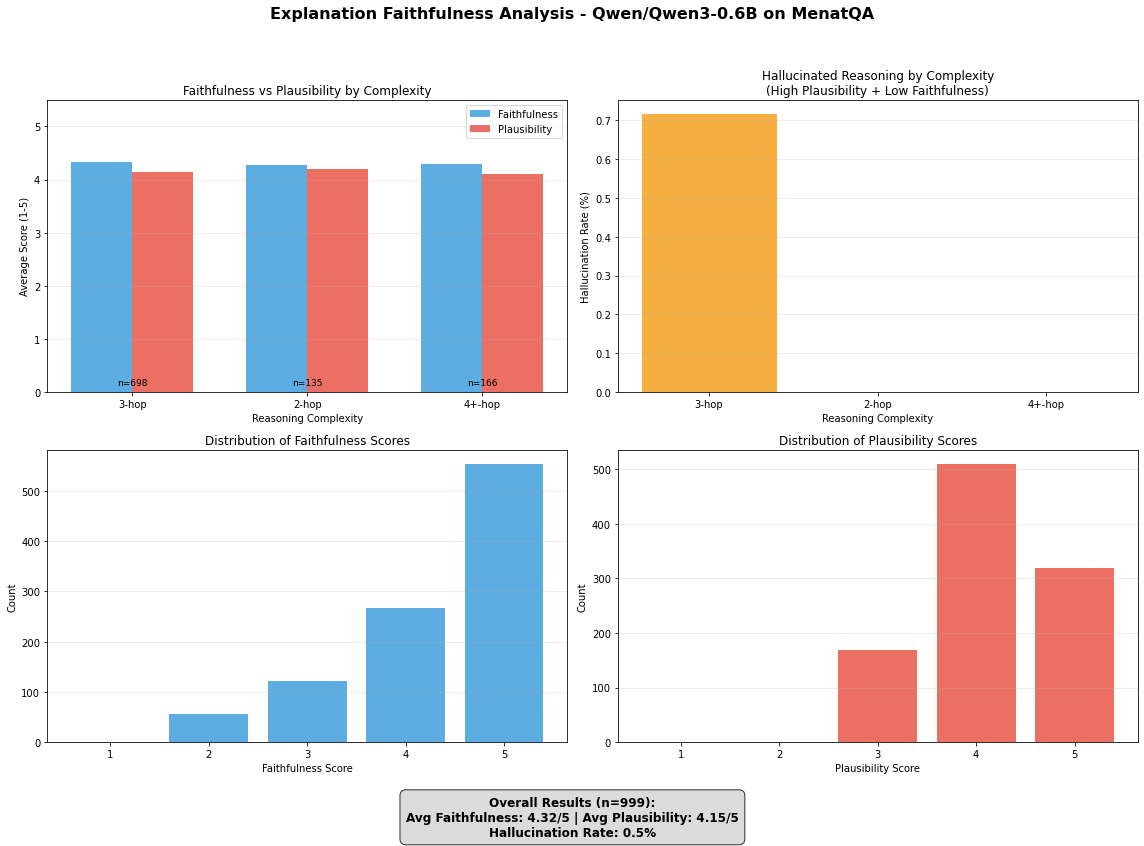

Saving detailed results...

--- Example Cases ---

GOOD EXPLANATION (Faithfulness=5, Plausibility=5):
Question: Which team did the player Attaphol Buspakom belong to from 1996 to 1998?
Gold Answer: Thailand national football team
Model Answer: But how does that work? If the team is the same name, then the answer would be the team's name. But the answer given is just "Buspakom". That seems like a mistake.
Explanation Steps: ['Buspakom was a player for the team of the same name, and he was a member of the 1996–97 and 1997–98 seasons. So, the answer is Buspakom.', 'Answer: Buspakom']...

HALLUCINATED REASONING (Faithfulness=2, Plausibility=4):
Question: Which position did Peter Beattie hold from Dec 1989 to 1996?
Gold Answer: Queensland Parliament as MP for Brisbane Central
Model Answer: Explanation: The first president of the United Nations General Assembly
Explanation Steps: ['He was the first president of the United Nations General Assembly, and he was the first president of the United

In [2]:
# explanation_faithfulness_evaluation.py

import json
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import torch
from pathlib import Path

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# --- DATA LOADING ---
def load_menatqa_dataset(file_path='./MenatQA.json'):
    file_path = Path(file_path)
    
    if not file_path.exists():
        import urllib.request
        print(f"Downloading MenatQA to {file_path}...")
        urllib.request.urlretrieve(
            "https://raw.githubusercontent.com/weiyifan1023/MenatQA/main/datasets/MenatQA.json",
            str(file_path)
        )
    
    with open(file_path, 'r') as f:
        data = json.load(f)
    print(f"Loaded MenatQA dataset with {len(data)} examples")
    return data

def extract_reasoning_hops(example):
    question = example.get('question', '')
    answer = example.get('answer', '')
    q_type = example.get('type', '')
    time_scope = example.get('time_scope', '')
    
    sentences = [s.strip() for s in question.split('.') if s.strip()]
    clauses = len([c for c in re.split(r'and|or|but|because|when|if', question.lower()) if c.strip()])
    capitalized_words = len([w for w in question.split() if w and w[0].isupper()])
    
    complexity_score = 1
    complexity_score += min(1, len(sentences) - 1)
    complexity_score += min(1, (clauses - 1) // 2)
    complexity_score += min(1, capitalized_words // 3)
    if time_scope:
        complexity_score += 1
    complexity_score = min(4, max(1, complexity_score))
    
    return complexity_score

def preprocess_dataset(data):
    processed_data = []
    hop_counts = {1: 0, 2: 0, 3: 0, 4: 0}
    
    for item in data:
        complexity_score = extract_reasoning_hops(item)
        hop_counts[min(4, complexity_score)] += 1
        
        entry = {
            'ID': item.get('ID', ''),
            'question': item.get('question', ''),
            'answer': item.get('answer', ''),
            'type': item.get('type', ''),
            'time_scope': item.get('time_scope', ''),
            'hop_count': complexity_score,
            'model_prediction': '',
            'model_reasoning_steps': []
        }
        processed_data.append(entry)
    
    df = pd.DataFrame(processed_data)
    df['hop_category'] = pd.cut(
        df['hop_count'],
        bins=[-1, 1, 2, 3, float('inf')],
        labels=['1-hop', '2-hop', '3-hop', '4+-hop']
    )
    
    print(f"Dataset preprocessed: {len(df)} questions")
    for i in range(1, 5):
        print(f"{i}-hop questions: {hop_counts[i]} ({hop_counts[i]/len(df):.1%})")
    
    return df

# --- MODEL GENERATION ---
def run_qwen_predictions_with_explanations(df, model_name="Qwen/Qwen3-0.6B"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Loading {model_name} on {device}...")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device)
    
    pipe = pipeline(
        "text-generation", 
        model=model, 
        tokenizer=tokenizer, 
        device=0 if device == 'cuda' else -1,
        max_new_tokens=256,
        temperature=0.01,
        do_sample=True
    )

    def format_explanation_prompt(question):
        return (f"Answer the following question and provide a detailed explanation for your reasoning. "
                f"Explain each step of your thinking process.\n"
                f"Question: {question}\n"
                f"Answer with explanation:")

    all_preds, all_steps = [], []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating predictions with explanations"):
        prompt = format_explanation_prompt(row["question"])
        generation = pipe(prompt)[0]['generated_text']
        output = generation[len(prompt):] if generation.startswith(prompt) else generation
        steps = [x.strip() for x in output.split('\n') if x.strip()]
        
        if not steps:
            steps = ["No explanation provided"]
            
        model_answer = steps[-1] if steps else "No answer"
        all_preds.append(model_answer)
        all_steps.append(steps)
    
    df = df.copy()
    df['model_prediction'] = all_preds
    df['model_reasoning_steps'] = all_steps
    return df

# --- FAITHFULNESS EVALUATION ---
def evaluate_faithfulness(question, gold_answer, model_prediction, model_steps):
    """
    Rate faithfulness (1-5): Does the explanation truly reflect the computation that produced the answer?
    """
    if not model_steps or len(model_steps) == 0:
        return 1
    
    score = 1
    explanation_text = ' '.join(model_steps).lower()
    question_lower = question.lower()
    gold_answer_lower = str(gold_answer).lower()
    model_prediction_lower = str(model_prediction).lower()
    
    # Check if explanation mentions key elements from question
    question_keywords = set(re.findall(r'\b\w+\b', question_lower))
    explanation_keywords = set(re.findall(r'\b\w+\b', explanation_text))
    question_overlap = len(question_keywords & explanation_keywords) / len(question_keywords) if question_keywords else 0
    
    if question_overlap >= 0.3:
        score += 1
    
    # Check if explanation leads to the predicted answer
    if model_prediction_lower.strip() in explanation_text or any(word in explanation_text for word in model_prediction_lower.split() if len(word) > 2):
        score += 1
    
    # Check logical flow in steps
    if len(model_steps) >= 2:
        logical_flow = 0
        for i in range(len(model_steps) - 1):
            current_step = model_steps[i].lower()
            next_step = model_steps[i + 1].lower()
            current_words = set(re.findall(r'\b\w+\b', current_step))
            next_words = set(re.findall(r'\b\w+\b', next_step))
            if len(current_words & next_words) > 0:
                logical_flow += 1
        
        if logical_flow >= len(model_steps) * 0.3:
            score += 1
    
    # Check if reasoning addresses the question type appropriately
    reasoning_indicators = ['because', 'since', 'therefore', 'thus', 'so', 'hence', 'as a result']
    if any(indicator in explanation_text for indicator in reasoning_indicators):
        score += 1
    
    return min(5, score)

def evaluate_plausibility(question, model_prediction, model_steps):
    """
    Rate plausibility (1-5): Is the explanation convincing, regardless of correctness?
    """
    if not model_steps or len(model_steps) == 0:
        return 1
    
    score = 1
    explanation_text = ' '.join(model_steps).lower()
    
    # Check explanation length and detail
    total_words = len(explanation_text.split())
    if total_words >= 10:
        score += 1
    if total_words >= 20:
        score += 1
    
    # Check for structured reasoning
    structured_indicators = ['first', 'second', 'next', 'then', 'finally', 'step', 'because', 'therefore']
    structure_count = sum(1 for indicator in structured_indicators if indicator in explanation_text)
    if structure_count >= 2:
        score += 1
    
    # Check for domain-appropriate vocabulary
    domain_terms = ['year', 'time', 'period', 'event', 'history', 'occurred', 'happened', 'during', 'after', 'before']
    domain_count = sum(1 for term in domain_terms if term in explanation_text)
    if domain_count >= 2:
        score += 1
    
    # Check coherence (no contradictions or nonsensical statements)
    coherence_flags = ['not not', 'never always', 'impossible possible', 'true false']
    has_contradictions = any(flag in explanation_text for flag in coherence_flags)
    if not has_contradictions and len(model_steps) > 1:
        coherent_flow = True
        for step in model_steps:
            if len(step.strip()) < 3 or step.strip().count(' ') == 0:
                coherent_flow = False
                break
        if coherent_flow:
            score += 1
    
    return min(5, score)

def evaluate_explanation_faithfulness(df):
    """
    Evaluate faithfulness and plausibility of model explanations
    """
    faithfulness_scores = []
    plausibility_scores = []
    hallucinated_reasoning_count = 0
    total_evaluated = 0
    
    category_results = defaultdict(lambda: {
        'faithfulness_scores': [], 
        'plausibility_scores': [], 
        'hallucinated_count': 0, 
        'total': 0
    })
    
    detailed_results = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating explanation faithfulness"):
        question = row['question']
        gold_answer = row['answer']
        model_prediction = row['model_prediction']
        model_steps = row['model_reasoning_steps']
        hop_category = row['hop_category']
        
        if not model_steps or not model_steps[0] or hop_category is None:
            continue
            
        total_evaluated += 1
        category_results[hop_category]['total'] += 1
        
        # Evaluate Faithfulness (1-5)
        faithfulness = evaluate_faithfulness(question, gold_answer, model_prediction, model_steps)
        
        # Evaluate Plausibility (1-5)
        plausibility = evaluate_plausibility(question, model_prediction, model_steps)
        
        faithfulness_scores.append(faithfulness)
        plausibility_scores.append(plausibility)
        category_results[hop_category]['faithfulness_scores'].append(faithfulness)
        category_results[hop_category]['plausibility_scores'].append(plausibility)
        
        # Detect hallucinated reasoning (high plausibility + low faithfulness)
        is_hallucinated = plausibility >= 4 and faithfulness <= 2
        if is_hallucinated:
            hallucinated_reasoning_count += 1
            category_results[hop_category]['hallucinated_count'] += 1
        
        # Store detailed results
        detailed_results.append({
            'ID': row['ID'],
            'question': question,
            'gold_answer': gold_answer,
            'model_prediction': model_prediction,
            'model_steps': model_steps,
            'hop_category': hop_category,
            'faithfulness_score': faithfulness,
            'plausibility_score': plausibility,
            'is_hallucinated': is_hallucinated
        })
    
    # Calculate overall metrics
    avg_faithfulness = np.mean(faithfulness_scores) if faithfulness_scores else 0
    avg_plausibility = np.mean(plausibility_scores) if plausibility_scores else 0
    hallucination_rate = hallucinated_reasoning_count / total_evaluated if total_evaluated > 0 else 0
    
    # Calculate category-wise metrics
    category_metrics = {}
    for category, data in category_results.items():
        if data['total'] > 0:
            category_metrics[str(category)] = {
                'avg_faithfulness': np.mean(data['faithfulness_scores']) if data['faithfulness_scores'] else 0,
                'avg_plausibility': np.mean(data['plausibility_scores']) if data['plausibility_scores'] else 0,
                'hallucination_rate': data['hallucinated_count'] / data['total'],
                'total_samples': data['total']
            }
    
    results = {
        'overall_faithfulness': avg_faithfulness,
        'overall_plausibility': avg_plausibility,
        'overall_hallucination_rate': hallucination_rate,
        'total_evaluated': total_evaluated,
        'by_category': category_metrics,
        'faithfulness_distribution': {
            '1': sum(1 for s in faithfulness_scores if s == 1),
            '2': sum(1 for s in faithfulness_scores if s == 2),
            '3': sum(1 for s in faithfulness_scores if s == 3),
            '4': sum(1 for s in faithfulness_scores if s == 4),
            '5': sum(1 for s in faithfulness_scores if s == 5)
        },
        'plausibility_distribution': {
            '1': sum(1 for s in plausibility_scores if s == 1),
            '2': sum(1 for s in plausibility_scores if s == 2),
            '3': sum(1 for s in plausibility_scores if s == 3),
            '4': sum(1 for s in plausibility_scores if s == 4),
            '5': sum(1 for s in plausibility_scores if s == 5)
        },
        'detailed_results': detailed_results
    }
    
    return results

# --- VISUALIZATION ---
def visualize_faithfulness_results(faithfulness_results, save_path=None):
    """
    Visualize explanation faithfulness and plausibility results
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Overall Faithfulness vs Plausibility by Category
    categories = [cat for cat in faithfulness_results['by_category'].keys()]
    faithfulness_scores = [faithfulness_results['by_category'][cat]['avg_faithfulness'] for cat in categories]
    plausibility_scores = [faithfulness_results['by_category'][cat]['avg_plausibility'] for cat in categories]
    
    x = np.arange(len(categories))
    width = 0.35
    
    ax1.bar(x - width/2, faithfulness_scores, width, label='Faithfulness', color='#3498db', alpha=0.8)
    ax1.bar(x + width/2, plausibility_scores, width, label='Plausibility', color='#e74c3c', alpha=0.8)
    ax1.set_xlabel('Reasoning Complexity')
    ax1.set_ylabel('Average Score (1-5)')
    ax1.set_title('Faithfulness vs Plausibility by Complexity')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    ax1.legend()
    ax1.set_ylim(0, 5.5)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add sample counts
    for i, cat in enumerate(categories):
        count = faithfulness_results['by_category'][cat]['total_samples']
        ax1.text(i, 0.1, f'n={count}', ha='center', va='bottom', fontsize=9)
    
    # 2. Hallucination Rate by Category
    hallucination_rates = [faithfulness_results['by_category'][cat]['hallucination_rate'] * 100 for cat in categories]
    ax2.bar(categories, hallucination_rates, color='#f39c12', alpha=0.8)
    ax2.set_xlabel('Reasoning Complexity')
    ax2.set_ylabel('Hallucination Rate (%)')
    ax2.set_title('Hallucinated Reasoning by Complexity\n(High Plausibility + Low Faithfulness)')
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Faithfulness Distribution
    faith_dist = faithfulness_results['faithfulness_distribution']
    scores = list(faith_dist.keys())
    counts = list(faith_dist.values())
    ax3.bar(scores, counts, color='#3498db', alpha=0.8)
    ax3.set_xlabel('Faithfulness Score')
    ax3.set_ylabel('Count')
    ax3.set_title('Distribution of Faithfulness Scores')
    ax3.grid(axis='y', alpha=0.3)
    
        # 4. Plausibility Distribution
    plaus_dist = faithfulness_results['plausibility_distribution']
    scores = list(plaus_dist.keys())
    counts = list(plaus_dist.values())
    ax4.bar(scores, counts, color='#e74c3c', alpha=0.8)
    ax4.set_xlabel('Plausibility Score')
    ax4.set_ylabel('Count')
    ax4.set_title('Distribution of Plausibility Scores')
    ax4.grid(axis='y', alpha=0.3)
    
    # Add overall statistics
    overall_text = (f"Overall Results (n={faithfulness_results['total_evaluated']}):\n"
                   f"Avg Faithfulness: {faithfulness_results['overall_faithfulness']:.2f}/5 | "
                   f"Avg Plausibility: {faithfulness_results['overall_plausibility']:.2f}/5\n"
                   f"Hallucination Rate: {faithfulness_results['overall_hallucination_rate']:.1%}")
    
    fig.suptitle('Explanation Faithfulness Analysis - Qwen/Qwen3-0.6B on MenatQA', fontsize=16, fontweight='bold')
    plt.figtext(0.5, 0.02, overall_text, ha='center', fontsize=12, fontweight='bold',
                bbox=dict(facecolor='lightgray', alpha=0.8, boxstyle='round,pad=0.5'))
    
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Faithfulness visualization saved to {save_path}")
    plt.show()

# --- MAIN EXECUTION ---
if __name__ == '__main__':
    # Configuration
    DATASET_FILE = './MenatQA.json'
    MODEL_NAME = "Qwen/Qwen3-0.6B"
    OUTPUT_FAITHFULNESS_IMAGE = './menatqa_faithfulness_analysis.png'
    OUTPUT_FAITHFULNESS_RESULTS = './menatqa_faithfulness_results.json'

    print("=== MenatQA Explanation Faithfulness Evaluation ===\n")
    
    # Load data
    print("Loading MenatQA dataset...")
    data = load_menatqa_dataset(DATASET_FILE)
    
    # Preprocess
    print("Preprocessing dataset...")
    df = preprocess_dataset(data)
    
    # Run model with explanation prompts
    print(f"Running {MODEL_NAME} with explanation prompts on {len(df)} questions...")
    df_results = run_qwen_predictions_with_explanations(df, model_name=MODEL_NAME)
    
    # Evaluate explanation faithfulness
    print("Evaluating explanation faithfulness...")
    faithfulness_results = evaluate_explanation_faithfulness(df_results)
    
    # Print results
    print("\n" + "="*60)
    print("EXPLANATION FAITHFULNESS RESULTS")
    print("="*60)
    
    print(f"\nOverall Results (n={faithfulness_results['total_evaluated']}):")
    print(f"Average Faithfulness: {faithfulness_results['overall_faithfulness']:.2f}/5")
    print(f"Average Plausibility: {faithfulness_results['overall_plausibility']:.2f}/5")
    print(f"Hallucination Rate: {faithfulness_results['overall_hallucination_rate']:.1%}")
    
    print("\n--- Results by Complexity Category ---")
    for category, metrics in faithfulness_results['by_category'].items():
        print(f"{category}: "
              f"Faithfulness={metrics['avg_faithfulness']:.2f}/5, "
              f"Plausibility={metrics['avg_plausibility']:.2f}/5, "
              f"Hallucination={metrics['hallucination_rate']:.1%} "
              f"(n={metrics['total_samples']})")
    
    print("\n--- Score Distributions ---")
    print("Faithfulness Distribution:")
    for score, count in faithfulness_results['faithfulness_distribution'].items():
        percentage = count / faithfulness_results['total_evaluated'] * 100 if faithfulness_results['total_evaluated'] > 0 else 0
        print(f"  Score {score}: {count} ({percentage:.1f}%)")
    
    print("Plausibility Distribution:")
    for score, count in faithfulness_results['plausibility_distribution'].items():
        percentage = count / faithfulness_results['total_evaluated'] * 100 if faithfulness_results['total_evaluated'] > 0 else 0
        print(f"  Score {score}: {count} ({percentage:.1f}%)")
    
    # Visualize results
    print("\nGenerating faithfulness visualization...")
    visualize_faithfulness_results(
        faithfulness_results, 
        save_path=OUTPUT_FAITHFULNESS_IMAGE
    )
    
    # Save detailed results
    print("Saving detailed results...")
    with open(OUTPUT_FAITHFULNESS_RESULTS, 'w') as f:
        json.dump(faithfulness_results, f, indent=2)
    
    # Print some example cases
    print("\n--- Example Cases ---")
    detailed_results = faithfulness_results['detailed_results']
    
    # High faithfulness, high plausibility (good case)
    good_cases = [r for r in detailed_results if r['faithfulness_score'] >= 4 and r['plausibility_score'] >= 4]
    if good_cases:
        example = good_cases[0]
        print(f"\nGOOD EXPLANATION (Faithfulness={example['faithfulness_score']}, Plausibility={example['plausibility_score']}):")
        print(f"Question: {example['question']}")
        print(f"Gold Answer: {example['gold_answer']}")
        print(f"Model Answer: {example['model_prediction']}")
        print(f"Explanation Steps: {example['model_steps'][:2]}...")  # First 2 steps
    
    # Hallucinated reasoning cases
    hallucinated_cases = [r for r in detailed_results if r['is_hallucinated']]
    if hallucinated_cases:
        example = hallucinated_cases[0]
        print(f"\nHALLUCINATED REASONING (Faithfulness={example['faithfulness_score']}, Plausibility={example['plausibility_score']}):")
        print(f"Question: {example['question']}")
        print(f"Gold Answer: {example['gold_answer']}")
        print(f"Model Answer: {example['model_prediction']}")
        print(f"Explanation Steps: {example['model_steps'][:2]}...")  # First 2 steps
    
    # Low faithfulness, low plausibility (bad case)
    bad_cases = [r for r in detailed_results if r['faithfulness_score'] <= 2 and r['plausibility_score'] <= 2]
    if bad_cases:
        example = bad_cases[0]
        print(f"\nPOOR EXPLANATION (Faithfulness={example['faithfulness_score']}, Plausibility={example['plausibility_score']}):")
        print(f"Question: {example['question']}")
        print(f"Gold Answer: {example['gold_answer']}")
        print(f"Model Answer: {example['model_prediction']}")
        print(f"Explanation Steps: {example['model_steps'][:2]}...")  # First 2 steps
    
    print(f"\nEvaluation complete!")
    print(f"Detailed results saved to: {OUTPUT_FAITHFULNESS_RESULTS}")
    print(f"Visualization saved to: {OUTPUT_FAITHFULNESS_IMAGE}")